In [1]:
import bayes_opt
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt.util import load_logs

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd

from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import minmax_scale

import json

%matplotlib notebook

In [2]:
# code taken from BayesianOptimization module notebook:
# https://github.com/fmfn/BayesianOptimization/blob/master/examples/visualization.ipynb
def posterior(optimizer, x_obs, y_obs, grid):
  optimizer._gp.fit(x_obs, y_obs)

  mu, sigma = optimizer._gp.predict(grid, return_std=True)
  return mu, sigma

def plot_gp(optimizer, utility, command_params, paramName):
  x_lims = command_params[paramName]
  x = np.linspace(x_lims[0], x_lims[1], 10000).reshape(-1, 1)
  fig = plt.figure(figsize=(16, 10))
  steps = len(optimizer.space)
  fig.suptitle(
    'Gaussian Process and Utility Function for Param {} After {} Steps'.format(paramName, steps),
    fontdict={'size':30}
  )

  gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
  axis = plt.subplot(gs[0])
  acq = plt.subplot(gs[1])

  x_obs = np.array([[res["params"][paramName]] for res in optimizer.res])
  y_obs = np.array([res["target"] for res in optimizer.res])

  mu, sigma = posterior(optimizer, x_obs, y_obs, x)
  axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
  axis.plot(x, mu, '--', color='k', label='Prediction')

  axis.fill(np.concatenate([x, x[::-1]]), 
    np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
    alpha=.6, fc='c', ec='None', label='95% confidence interval')

  axis.set_xlim(x_lims)
  axis.set_ylim((None, None))
  axis.set_ylabel('-time (days)', fontdict={'size':20})
  axis.set_xlabel('x', fontdict={'size':20})

  utility_function = utility
  utility = utility_function.utility(x, optimizer._gp, 0)
  acq.plot(x, utility, label='Utility Function', color='purple')
  acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
    label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
  acq.set_xlim((-2, 10))
  acq.set_ylim((0, np.max(utility) + 0.5))
  acq.set_ylabel('Utility', fontdict={'size':20})
  acq.set_xlabel('x', fontdict={'size':20})

  axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
  acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

  # plt.savefig(os.path.dirname(os.path.realpath(__file__)) + '/paropt_steps-{}_param-{}.png'.format(steps, paramName))

In [3]:
params = {
  'nCPUs': (2, 24),
  'memPerCPU': (8, 32)
}

optimizer = BayesianOptimization(
  f=None,
  pbounds=params,
  verbose=2,
  random_state=1,
)

load_logs(optimizer, logs=["./bayes_logs.json"]);

orig_utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

In [4]:
# previously evaluated 6, 18 and 3, 8 (ncpus, mempercpu)
# had problem where it suggested 6, 18 again
# maybe it's due to our kappa value - the "explore vs. exploit" parameter of evaulting utility
kappaVals=np.arange(2, 100, 10)
for k in kappaVals:
    tmp_util = UtilityFunction(kind="ucb", kappa=k, xi=0.0)
    print(f"kapp: {k}, suggestion: {optimizer.suggest(tmp_util)}")

kapp: 2, suggestion: {'memPerCPU': 18.008409299927195, 'nCPUs': 6.3220209946439825}
kapp: 12, suggestion: {'memPerCPU': 18.009979227496054, 'nCPUs': 6.3227050803873714}
kapp: 22, suggestion: {'memPerCPU': 18.010551973301254, 'nCPUs': 6.324192813354266}
kapp: 32, suggestion: {'memPerCPU': 18.004165388276018, 'nCPUs': 6.322551557622431}
kapp: 42, suggestion: {'memPerCPU': 18.002778149736827, 'nCPUs': 6.321318315877648}
kapp: 52, suggestion: {'memPerCPU': 18.009691320589166, 'nCPUs': 6.329015331548249}
kapp: 62, suggestion: {'memPerCPU': 18.00016869827407, 'nCPUs': 6.323705318993872}
kapp: 72, suggestion: {'memPerCPU': 18.01284703271494, 'nCPUs': 6.330878566379745}
kapp: 82, suggestion: {'memPerCPU': 18.001915100345595, 'nCPUs': 6.33110925190316}
kapp: 92, suggestion: {'memPerCPU': 18.020759330405866, 'nCPUs': 6.318611272272176}


In [5]:
# in the examples from the bayes opt package, they used pretty small kappa (1 to 10)
# but maybe it's relative to the difference in the values you're optimizing...
# with mine, the difference is -12511 - -15922 = 3400

# looks like if I bump kappa up to ~30K or 40K it is moving around a bit more.
kappaVals=np.arange(2, 100000, 10000)
for k in kappaVals:
    tmp_util = UtilityFunction(kind="ucb", kappa=k, xi=0.0)
    print(f"kapp: {k}, suggestion: {optimizer.suggest(tmp_util)}")

kapp: 2, suggestion: {'memPerCPU': 18.008673377007796, 'nCPUs': 6.321958931955716}
kapp: 10002, suggestion: {'memPerCPU': 18.398430348150377, 'nCPUs': 6.734409521557648}
kapp: 20002, suggestion: {'memPerCPU': 17.47398032212049, 'nCPUs': 6.779038249161925}
kapp: 30002, suggestion: {'memPerCPU': 17.389907067654974, 'nCPUs': 6.7965078895251105}
kapp: 40002, suggestion: {'memPerCPU': 18.23761362168565, 'nCPUs': 5.521400514053913}
kapp: 50002, suggestion: {'memPerCPU': 17.33772293797916, 'nCPUs': 6.880958783896762}
kapp: 60002, suggestion: {'memPerCPU': 18.35282560924171, 'nCPUs': 7.1599291322576715}
kapp: 70002, suggestion: {'memPerCPU': 18.845379834043452, 'nCPUs': 6.735421142810973}
kapp: 80002, suggestion: {'memPerCPU': 18.387942670081735, 'nCPUs': 5.443304434954919}
kapp: 90002, suggestion: {'memPerCPU': 17.251088392232152, 'nCPUs': 5.7035846642715695}


In [6]:
# Testing optimizer where I only load ncpus


In [7]:
params2 = {
  'nCPUs': (2, 24),
}

optimizer2 = BayesianOptimization(
  f=None,
  pbounds=params2,
  verbose=2,
  random_state=1,
)

load_logs(optimizer2, logs=["./bayes_logs_cpu.json"]);

orig_utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

In [8]:
kappaVals = np.arange(1, 30, 2)
for k in kappaVals:
    tmp_util = UtilityFunction(kind="ucb", kappa=k, xi=0.0)
    print(f"kapp: {k}, suggestion: {optimizer2.suggest(tmp_util)}")

kapp: 1, suggestion: {'nCPUs': 22.911161171576467}
kapp: 3, suggestion: {'nCPUs': 6.32199219645521}
kapp: 5, suggestion: {'nCPUs': 6.321932433060439}
kapp: 7, suggestion: {'nCPUs': 2.296692037096519}
kapp: 9, suggestion: {'nCPUs': 6.13213658763129}
kapp: 11, suggestion: {'nCPUs': 6.322033136035088}
kapp: 13, suggestion: {'nCPUs': 6.321783370031861}
kapp: 15, suggestion: {'nCPUs': 6.321856130480881}
kapp: 17, suggestion: {'nCPUs': 5.5284746118412595}
kapp: 19, suggestion: {'nCPUs': 6.321952789454028}
kapp: 21, suggestion: {'nCPUs': 6.3219517528143525}
kapp: 23, suggestion: {'nCPUs': 6.321856970699547}
kapp: 25, suggestion: {'nCPUs': 6.321944402931925}
kapp: 27, suggestion: {'nCPUs': 6.321992626467746}
kapp: 29, suggestion: {'nCPUs': 6.321814841317325}


In [9]:
# but on second thought I realize that it's probably not wanting to move anywhere
# because of it's fit.
# see plots below

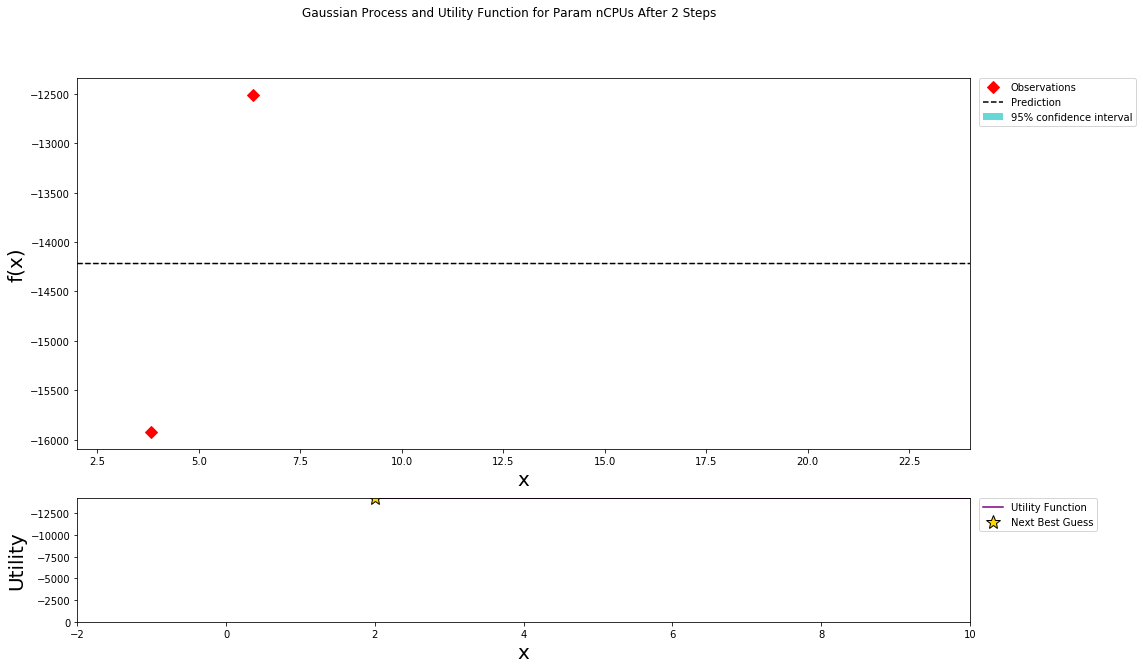

In [10]:
plot_gp(optimizer, orig_utility, params, 'nCPUs')

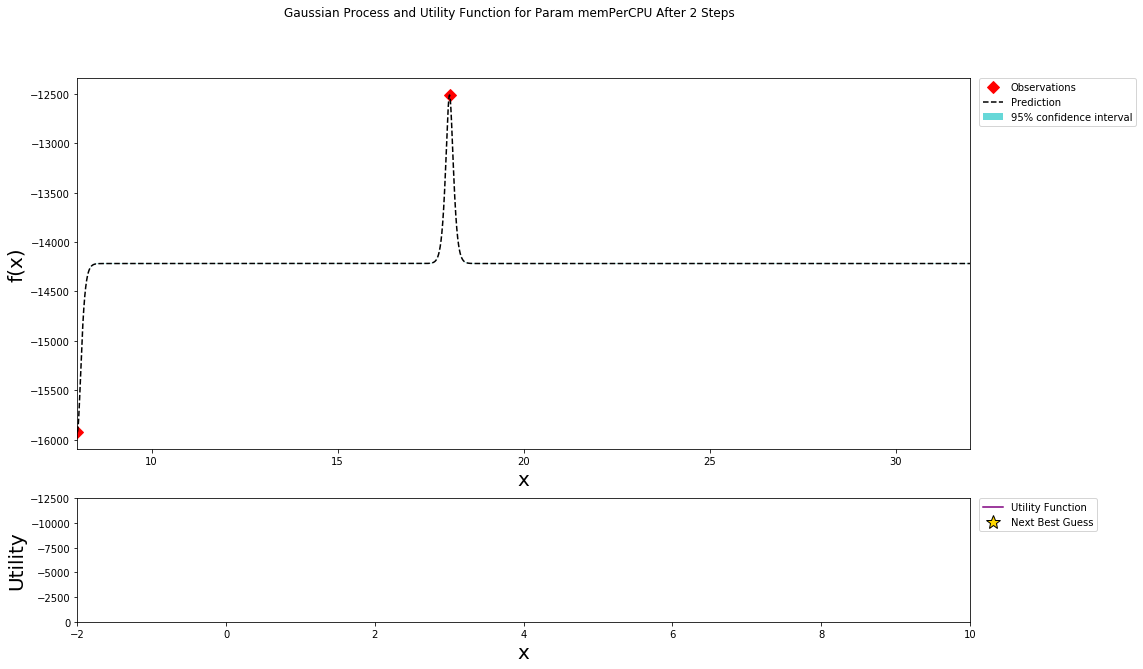

In [12]:
plot_gp(optimizer, orig_utility, params, 'memPerCPU')

our utility function, UCB, is looking optimistically at the CI and trying to find potential best improvement but the CI is so tight to our estimated function, and our estimated function is so ~weird~ that this won't work  
ie, the flat line between the points keeps them all equally good, except for a very small range where it spikes in the function estimation

Thus, the gaussian process regressor is what needs to be fixed.  

sklearn's GPR: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor

In [13]:
# get data points into lists

dataPoints = []
with open('./bayes_logs.json', 'r') as f:
    dataPoints = list(map(json.loads, f.readlines()))

cpu_obs = np.array([pt['params']['nCPUs'] for pt in dataPoints]).reshape(-1, 1)
mem_obs = np.array([pt['params']['memPerCPU'] for pt in dataPoints]).reshape(-1, 1)
targ_obs = np.array([pt['target'] for pt in dataPoints]).reshape(-1, 1)

cpu_xrange = np.linspace(params['nCPUs'][0], params['nCPUs'][1], 10000).reshape(-1, 1)
mem_xrange = np.linspace(params['memPerCPU'][0], params['memPerCPU'][1], 10000).reshape(-1, 1)

In [14]:
targ_obs

array([[-12511.9462173 ],
       [-15922.49312282]])

In [3]:
def fitAndPlot(gp, x_obs, y_obs, xrange, labels):
    gp.fit(x_obs, y_obs)
    mu, sigma = gp.predict(xrange, return_std=True)
    
    plt.figure(figsize=(15,8))
    plt.plot(xrange, mu, '--', label='prediction')
    xrange_rev = np.concatenate([xrange, xrange[::-1]]).ravel()
    muFill = np.concatenate([mu.ravel() - 1.9600 * sigma.ravel(), (mu.ravel() + 1.9600 * sigma.ravel())[::-1]])
    plt.fill(xrange_rev, muFill, alpha=.6, fc='c', ec='None', label='95% confidence interval')
    plt.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    plt.xlim((xrange[0], xrange[-1]))
    plt.xlabel(labels['xlabel'])
    plt.ylabel(labels['ylabel'])
    plt.title(labels['title'])
    plt.legend()
    plt.show()

def fitAndPlot2(gp, x_obs, y_obs, targ_obs, grid, shape, pov, labels, showSamples):
    # fit and predict gp
    gp.fit(np.hstack((x_obs, y_obs)), targ_obs)
    mu, sigma = gp.predict(grid, return_std=True)
    print("grid shape: ", grid.shape)
    print("mu shape: ", mu.shape)
    mu = mu.reshape(shape, shape)
    print("mu reshaped: ", mu.shape)
    

In [5]:
# same gp as in bayes opt package
bo_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(bo_gp, cpu_obs, targ_obs, cpu_xrange)
fitAndPlot(bo_gp, mem_obs, targ_obs, mem_xrange)

NameError: name 'cpu_obs' is not defined

Seems like I need to change the kernel being used by the GP

https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels



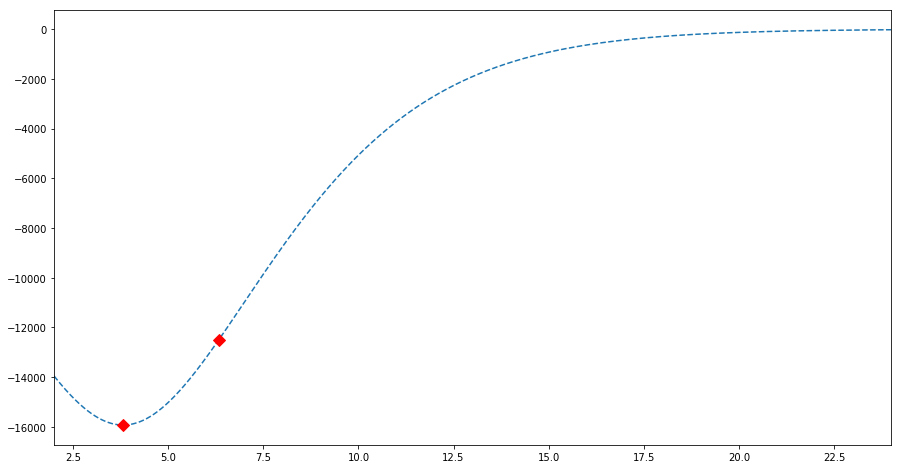

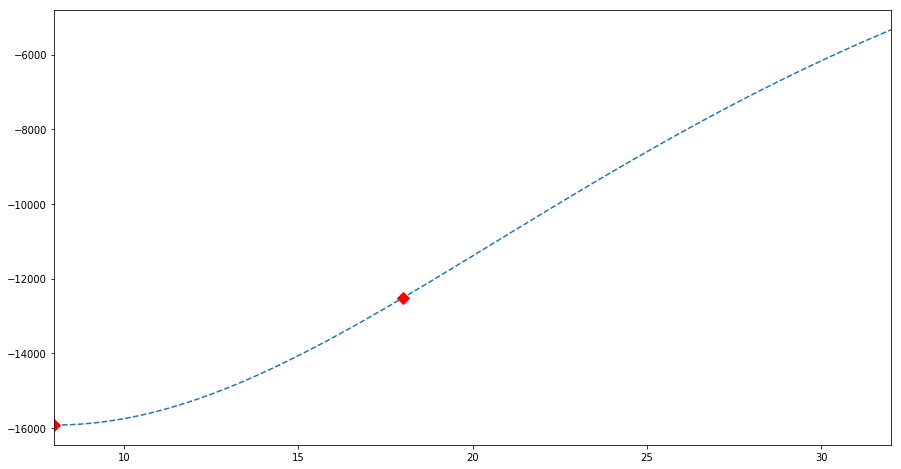

In [51]:
# modified gp
# set normalize_y to False
# don't think this should be the right solution, see comment on parameter below

# normalize_y : boolean, optional (default: False)
# Whether the target values y are normalized, i.e., the mean of the observed target values become zero. 
# This parameter should be set to True if the target values’ mean is expected to differ considerable from zero.
# When enabled, the normalization effectively modifies the GP’s prior based on the data, which contradicts the
# likelihood principle; normalization is thus disabled per default.

# our mean is definitely not centered around zero...

my_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=False,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(my_gp, cpu_obs, targ_obs, cpu_xrange)
fitAndPlot(my_gp, mem_obs, targ_obs, mem_xrange)

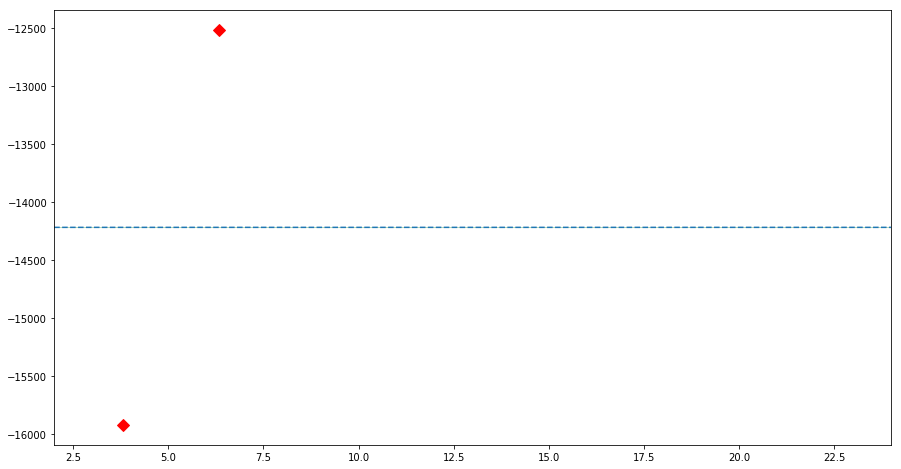

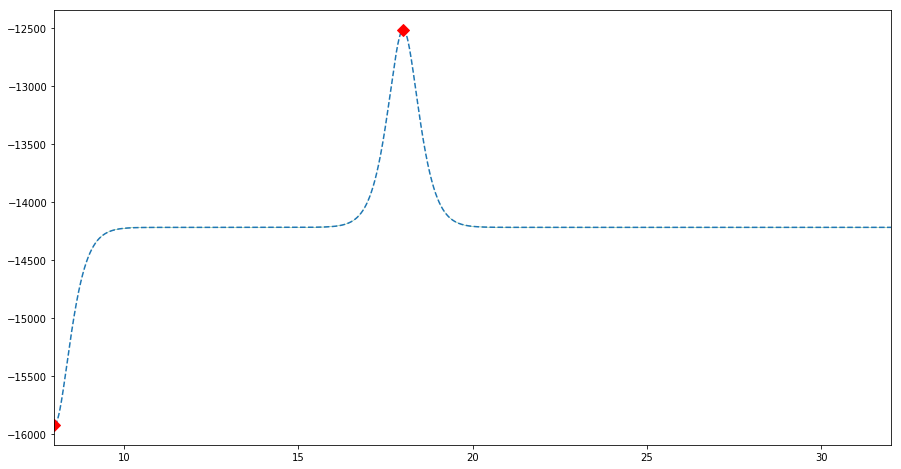

In [52]:
my_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5, length_scale=0.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(my_gp, cpu_obs, targ_obs, cpu_xrange)
fitAndPlot(my_gp, mem_obs, targ_obs, mem_xrange)

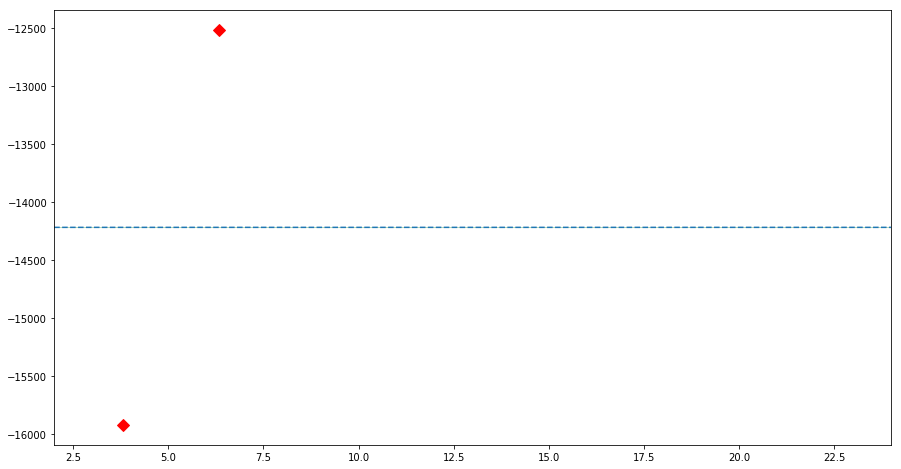

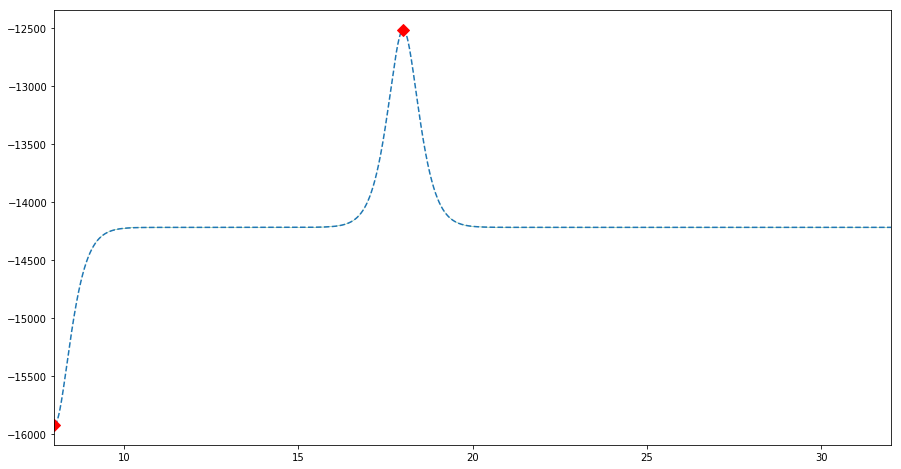

In [53]:
my_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5, length_scale=0.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(my_gp, cpu_obs, targ_obs, cpu_xrange)
fitAndPlot(my_gp, mem_obs, targ_obs, mem_xrange)

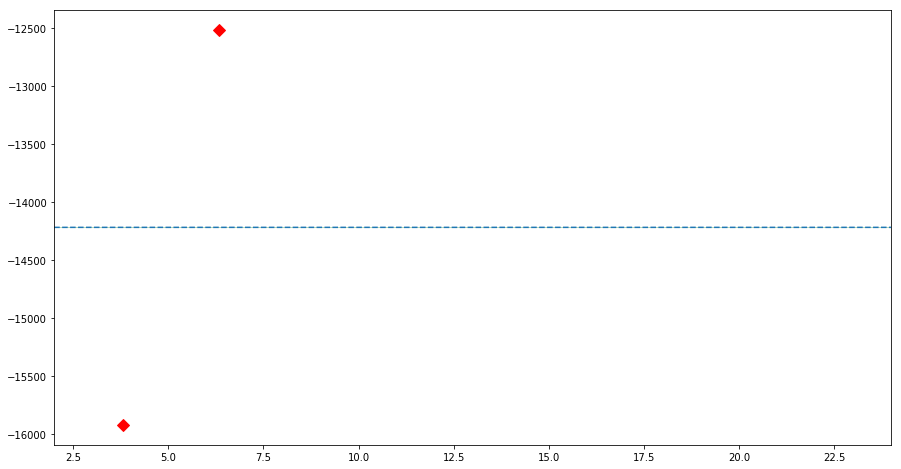

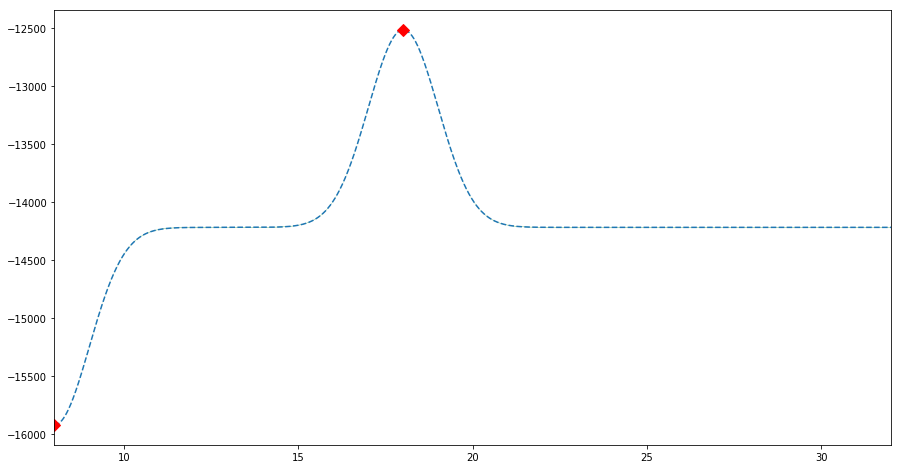

In [54]:
from sklearn.gaussian_process.kernels import RBF

my_gp = GaussianProcessRegressor(
    kernel=RBF(length_scale=1),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(my_gp, cpu_obs, targ_obs, cpu_xrange)
fitAndPlot(my_gp, mem_obs, targ_obs, mem_xrange)

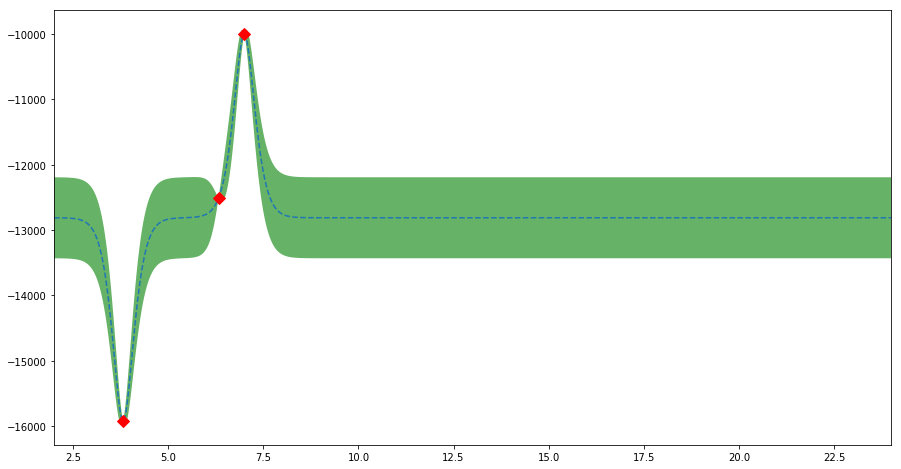

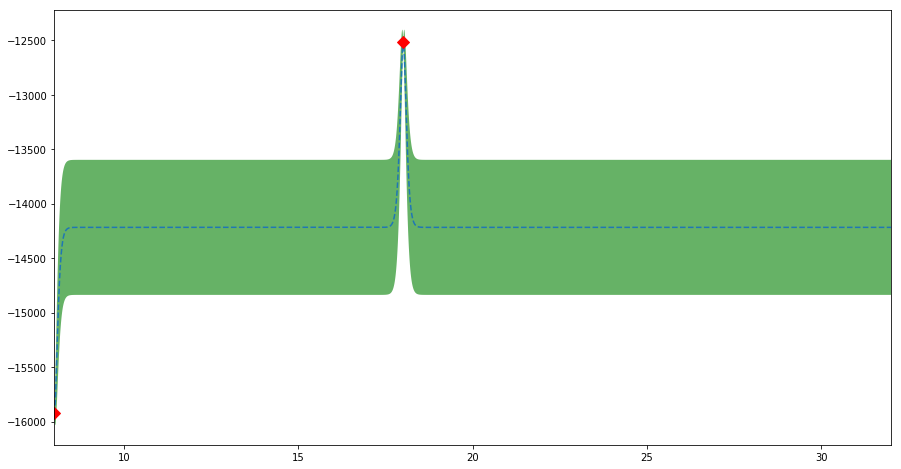

In [55]:
myKernel = ConstantKernel(1) * Matern(nu=2.5, length_scale=.1)
cpu_obs2 = np.concatenate([cpu_obs, np.array([7]).reshape(-1, 1)])
targ_obs2 = np.concatenate([targ_obs, np.array([-10000]).reshape(-1, 1)])
my_gp = GaussianProcessRegressor(
    kernel=myKernel,
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(my_gp, cpu_obs2, targ_obs2, cpu_xrange)
fitAndPlot(my_gp, mem_obs, targ_obs, mem_xrange)

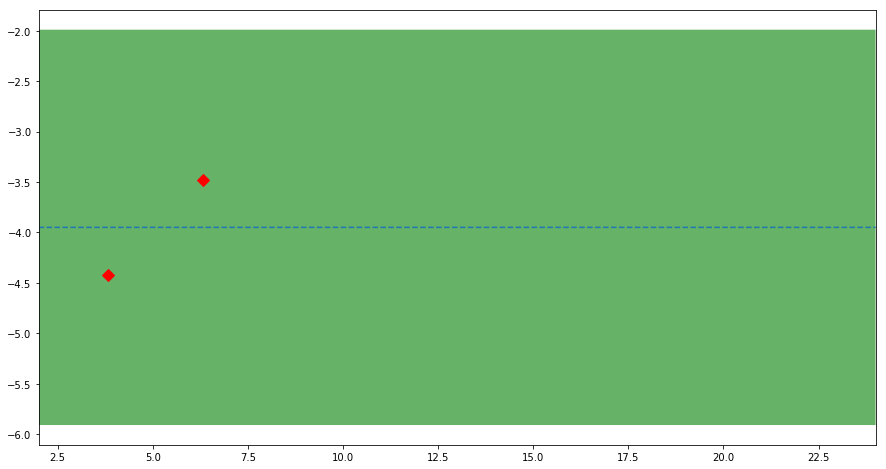

In [56]:
# Could changing the scale of our target variables matter?

targ_obs3 = targ_obs / 3600 # hours
myKernel = Matern(nu=2.5)
my_gp = GaussianProcessRegressor(
    kernel=myKernel,
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(my_gp, cpu_obs, targ_obs3, cpu_xrange)
# fitAndPlot(my_gp, mem_obs, targ_obs, mem_xrange)

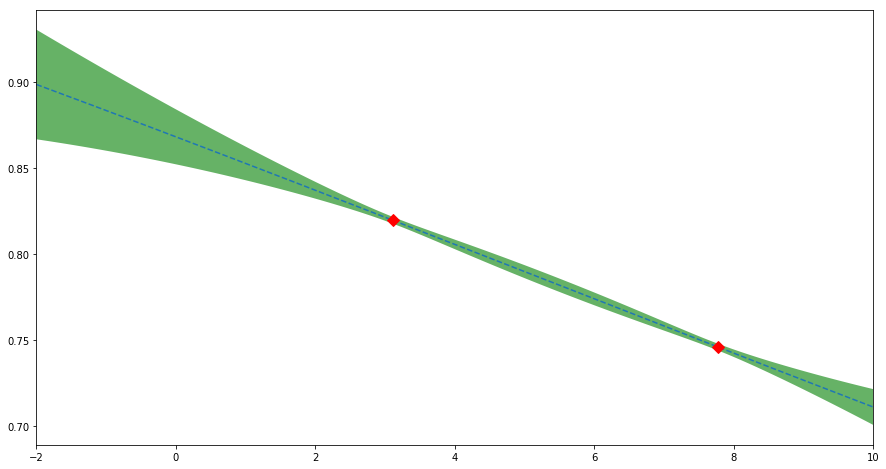

In [57]:
# testing to replicate figure from docs with my plotting
# https://github.com/fmfn/BayesianOptimization/blob/master/examples/visualization.ipynb
x_obs = np.array([3.109, 7.775]).reshape(-1, 1)
targs = np.array([0.8198, 0.746]).reshape(-1, 1)

bo_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(27),
)

xrange = np.linspace(-2, 10, 10000).reshape(-1, 1)
fitAndPlot(bo_gp, x_obs, targs, xrange)

Plot with points of difference: 1.0


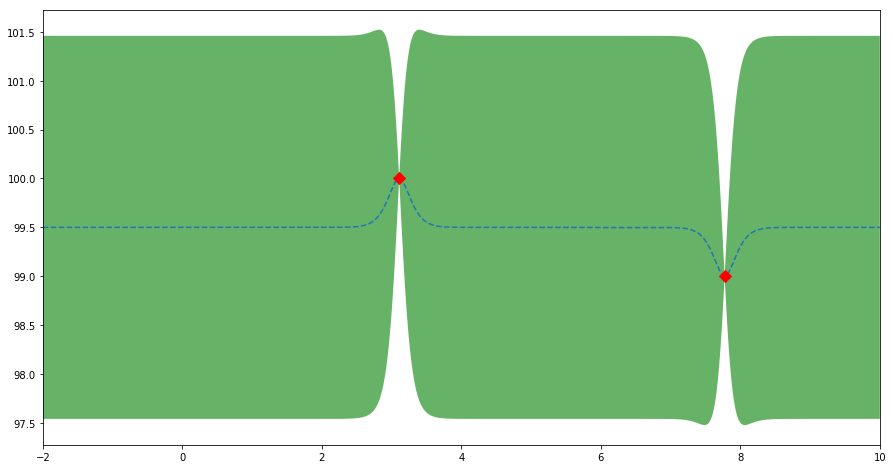

Plot with points of difference: 12.0


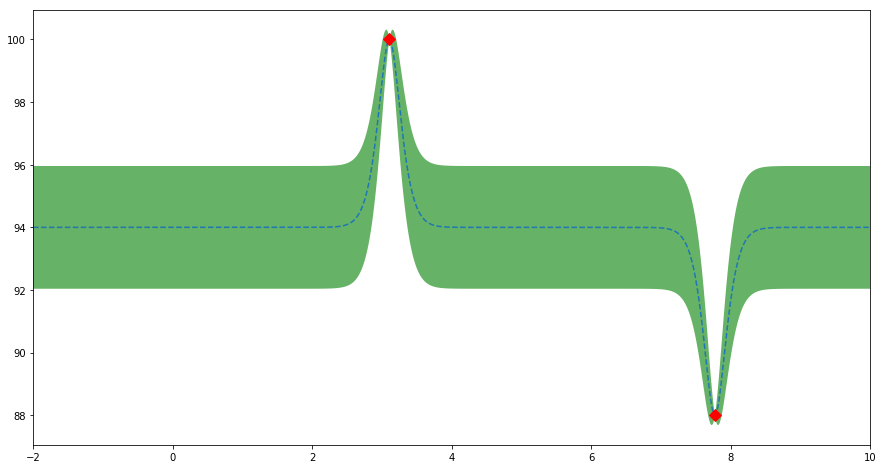

Plot with points of difference: 23.0


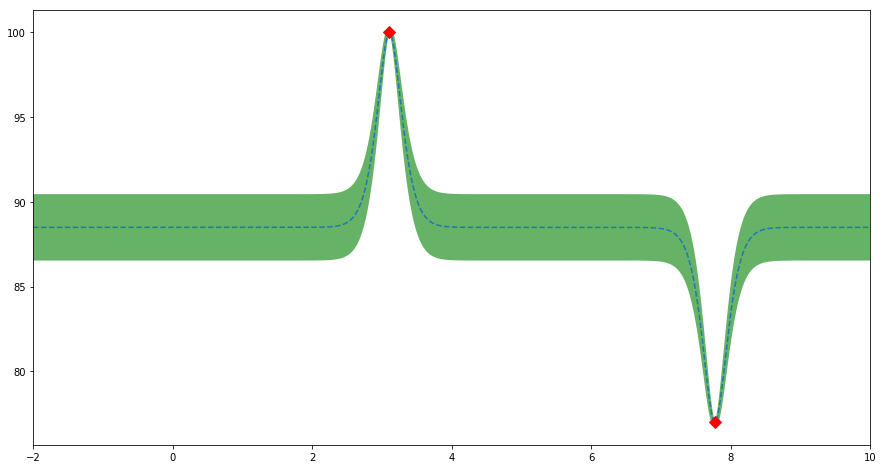

Plot with points of difference: 34.0


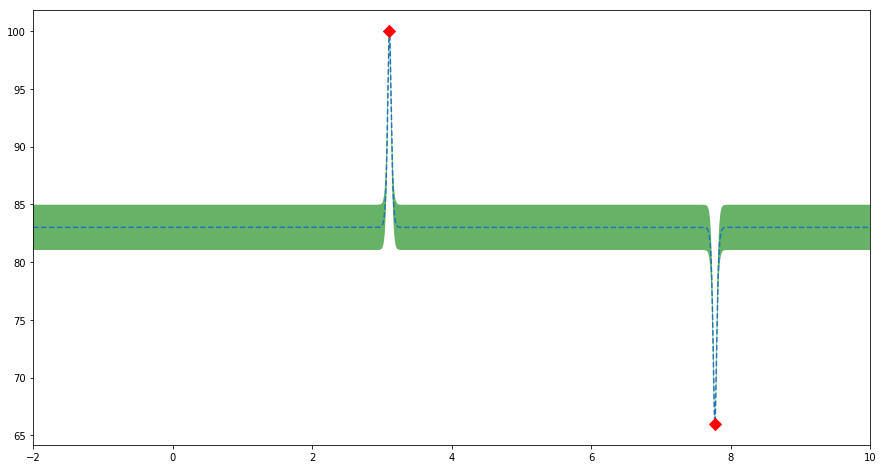

Plot with points of difference: 45.0


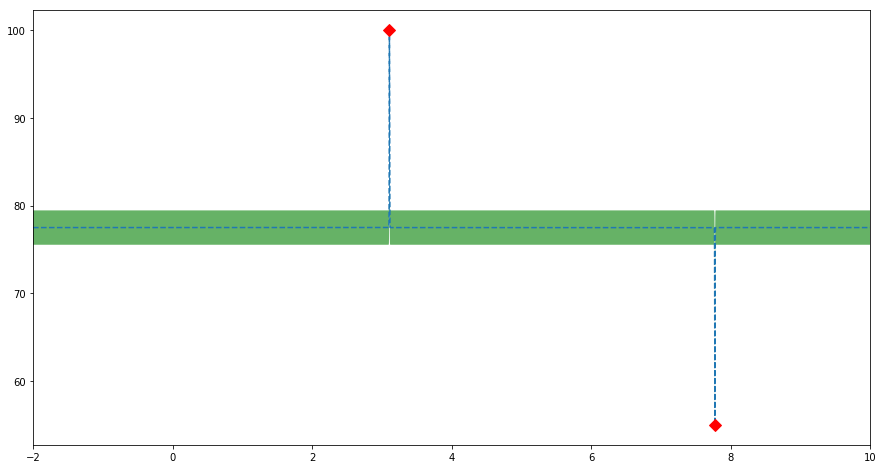

Plot with points of difference: 56.0


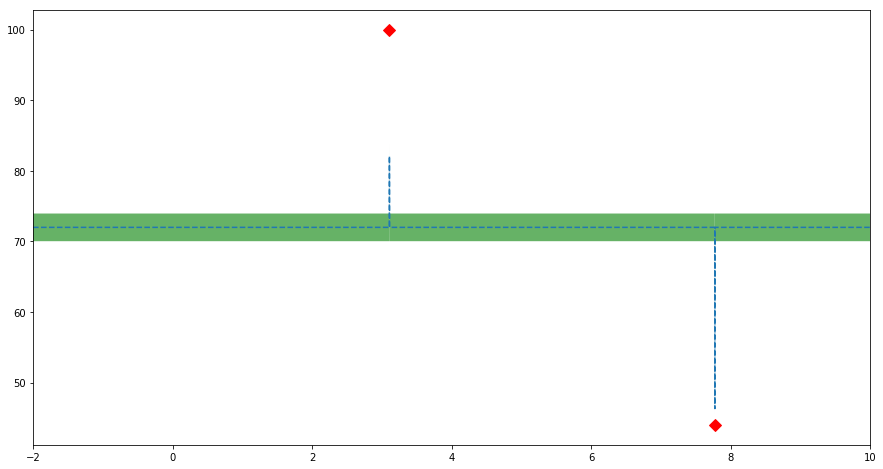

Plot with points of difference: 67.0


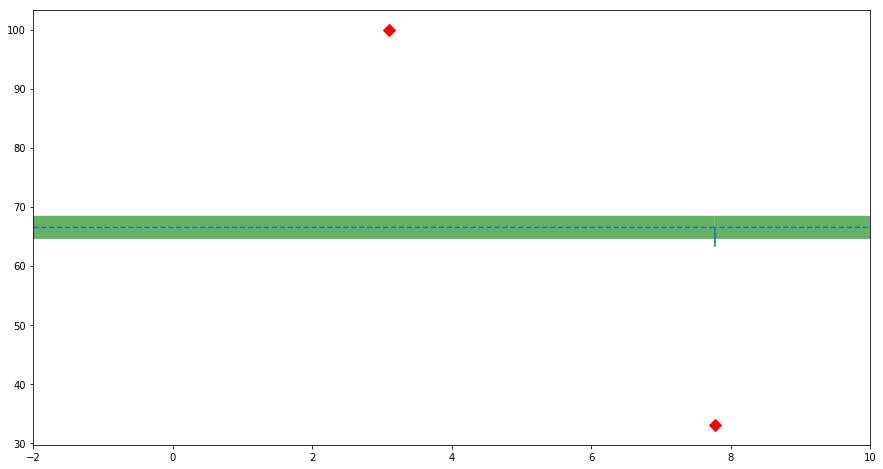

Plot with points of difference: 78.0


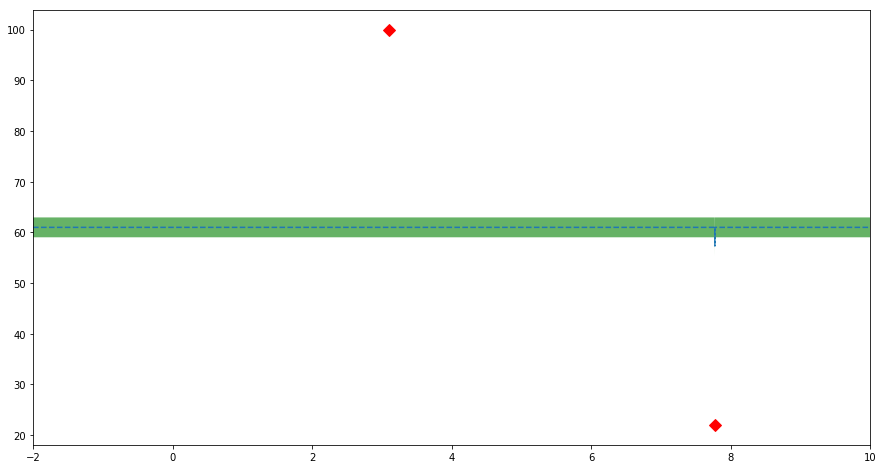

Plot with points of difference: 89.0


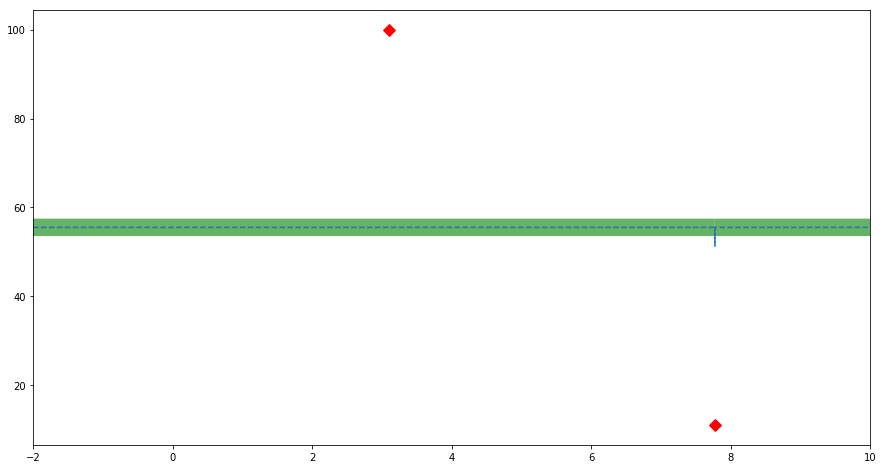

Plot with points of difference: 100.0


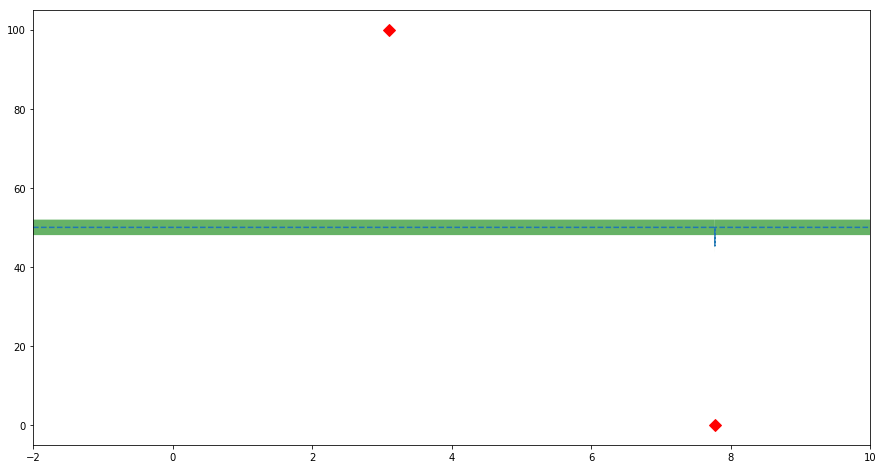

In [58]:
# testing how the difference in distance between samples affects outcome
# testing to replicate figure from docs with my plotting
# https://github.com/fmfn/BayesianOptimization/blob/master/examples/visualization.ipynb

diffRange = np.linspace(1, 100, 10)
x_obs = np.array([3.109, 7.775]).reshape(-1, 1)
xrange = np.linspace(-2, 10, 10000).reshape(-1, 1)

for diff in diffRange:
    bo_gp = GaussianProcessRegressor(
        kernel=Matern(nu=2.5),
        alpha=1e-6,
        normalize_y=True,
        n_restarts_optimizer=25,
        random_state=bayes_opt.util.ensure_rng(27),
    )
    targs = np.array([100, 100-diff]).reshape(-1, 1)
    print("Plot with points of difference: {}".format(diff))
    fitAndPlot(bo_gp, x_obs, targs, xrange)

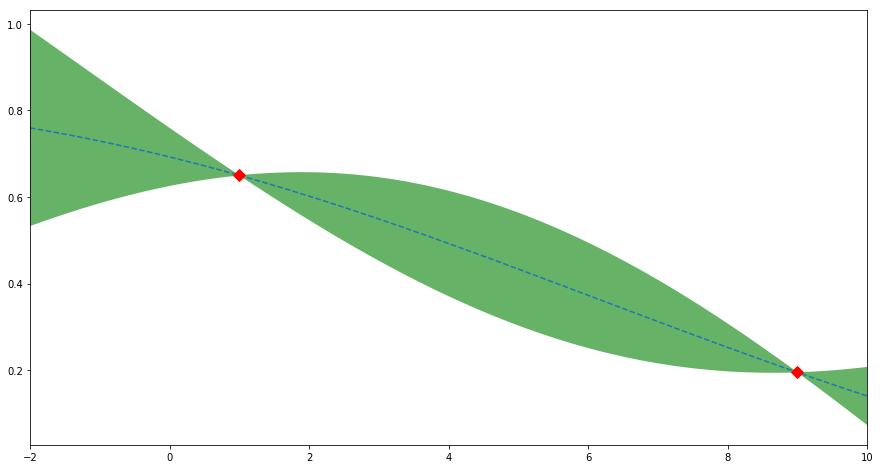

In [59]:
# Testing moving around the values that "worked" from the docs
# it appears that everything is fine and dandy until the difference between two consecutive points is > ~0.45
x_obs = np.array([1, 9]).reshape(-1, 1)

y_vals = np.array([0.5, .04478])
y_vals = y_vals + 0.15
targs = y_vals.reshape(-1, 1)

bo_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=False,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(27),
)

xrange = np.linspace(-2, 10, 10000).reshape(-1, 1)
fitAndPlot(bo_gp, x_obs, targs, xrange)

In [60]:
# Questions:
# why use bayes opt for simple curve fit
# how to keep scaling when transforming to fit in range (e.g the .5 range)

[[0.45]
 [0.  ]]


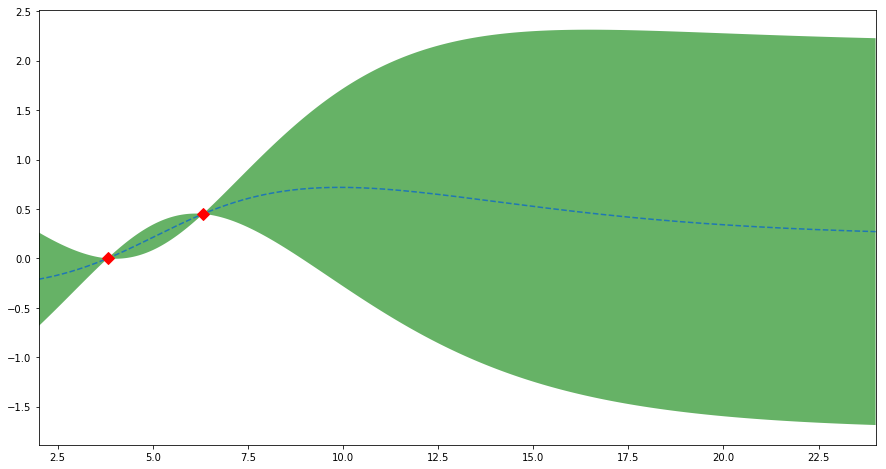

In [76]:
targ_obs_small = minmax_scale(targ_obs, feature_range=(0, 0.45))
print(targ_obs_small)
bo_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(bo_gp, cpu_obs, targ_obs_small, cpu_xrange)


In [78]:
# https://www.youtube.com/watch?v=4vGiHC35j9s
# after watching this video I am *very* confident our fit looks strange due to our kernel

In [141]:
# myKernel = ConstantKernel(0.01) * Matern(nu=2.5, length_scale=1)
# myKernel = ConstantKernel(1e-20, (1e-25, 1e-15))* RBF(length_scale=1)
myKernel = ConstantKernel(1000, (1000, 2000))* RBF(length_scale=1)
# cpu_obs2 = np.concatenate([cpu_obs, np.array([7]).reshape(-1, 1)])
# targ_obs2 = np.concatenate([targ_obs, np.array([-10000]).reshape(-1, 1)])
my_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=myKernel,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(my_gp, cpu_obs, targ_obs, cpu_xrange)
# fitAndPlot(my_gp, mem_obs, targ_obs, mem_xrange)

TypeError: ufunc 'add' output (typecode 'O') could not be coerced to provided output parameter (typecode 'd') according to the casting rule ''same_kind''

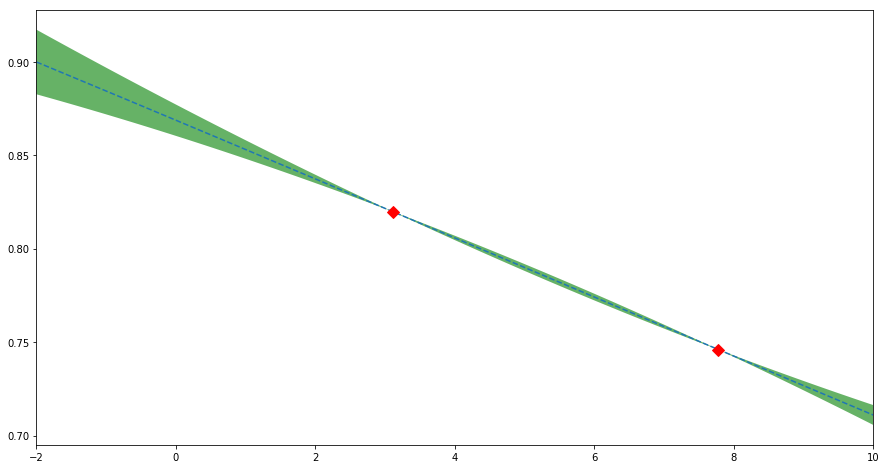

In [114]:
# messing with kernel of the thing we know looks good
myKernel =  RBF(length_scale=1)

x_obs = np.array([3.109, 7.775]).reshape(-1, 1)
targs = np.array([0.8198, 0.746]).reshape(-1, 1)

bo_gp = GaussianProcessRegressor(
    kernel=myKernel,
    alpha=1e-10,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(27),
)

xrange = np.linspace(-2, 10, 10000).reshape(-1, 1)
fitAndPlot(bo_gp, x_obs, targs, xrange)

[[-0.14481419]
 [-0.18428811]]


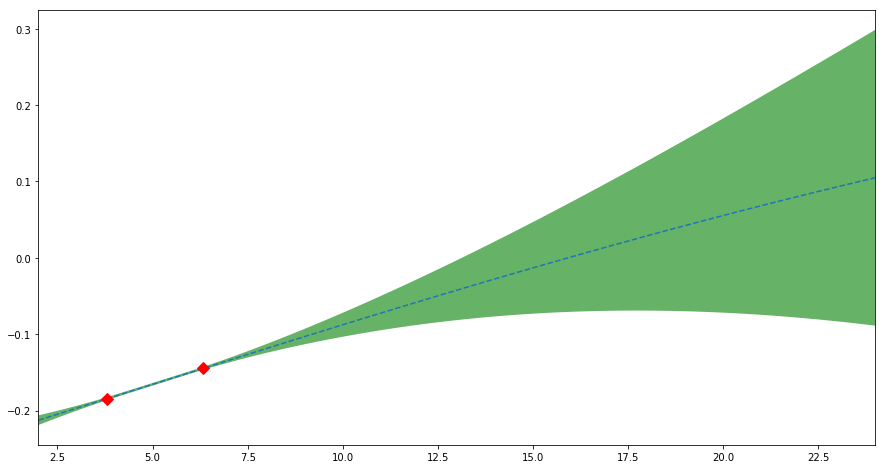

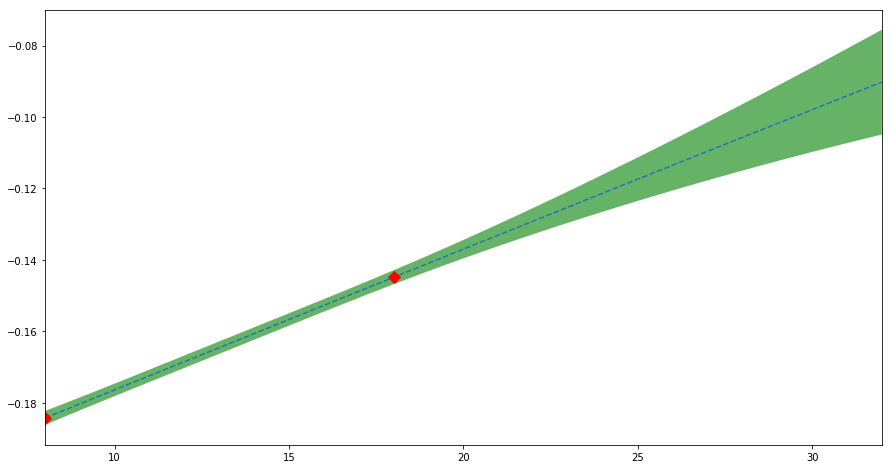

In [35]:
# turning seconds into DAYS
sec_per_day = 86400
sec_per_halfday = sec_per_day / 2
targ_obs_days = targ_obs / sec_per_day
print(targ_obs_days)

my_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)

fitAndPlot(my_gp, cpu_obs, targ_obs_days, cpu_xrange)
fitAndPlot(my_gp, mem_obs, targ_obs_days, mem_xrange)

In [124]:
# RERAN ON NSCC

params = {
  'nCPUs': (2, 24),
  'totalMem': (8, 96)
}

optimizer = BayesianOptimization(
  f=None,
  pbounds=params,
  verbose=2,
  random_state=1,
)

load_logs(optimizer, logs=["./bayes_logs_1549818579.json"]);

orig_utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)

In [125]:
print(optimizer._space.params)
print(optimizer._space.target)

[[11.1744841  71.38855542]
 [ 2.00251625 34.60526639]
 [ 2.         96.        ]
 [24.          8.        ]]
[-0.1189897  -0.26998179 -0.27278709 -0.13843117]


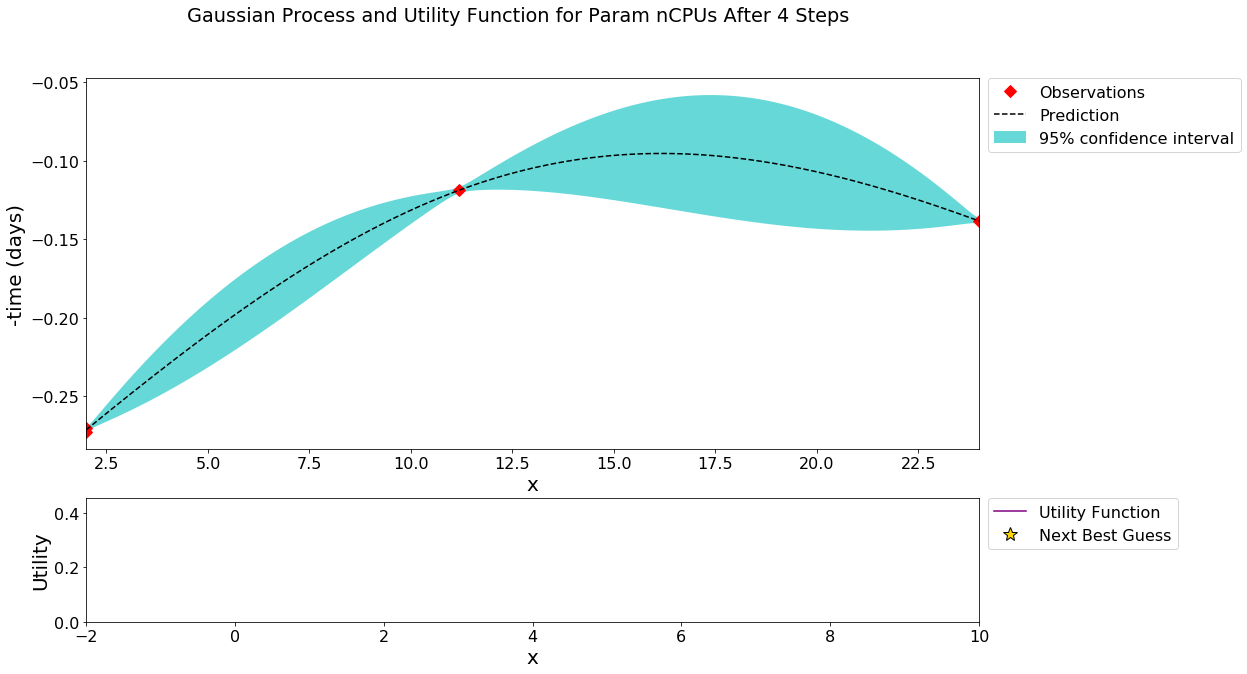

In [126]:
plot_gp(optimizer, orig_utility, params, 'nCPUs')

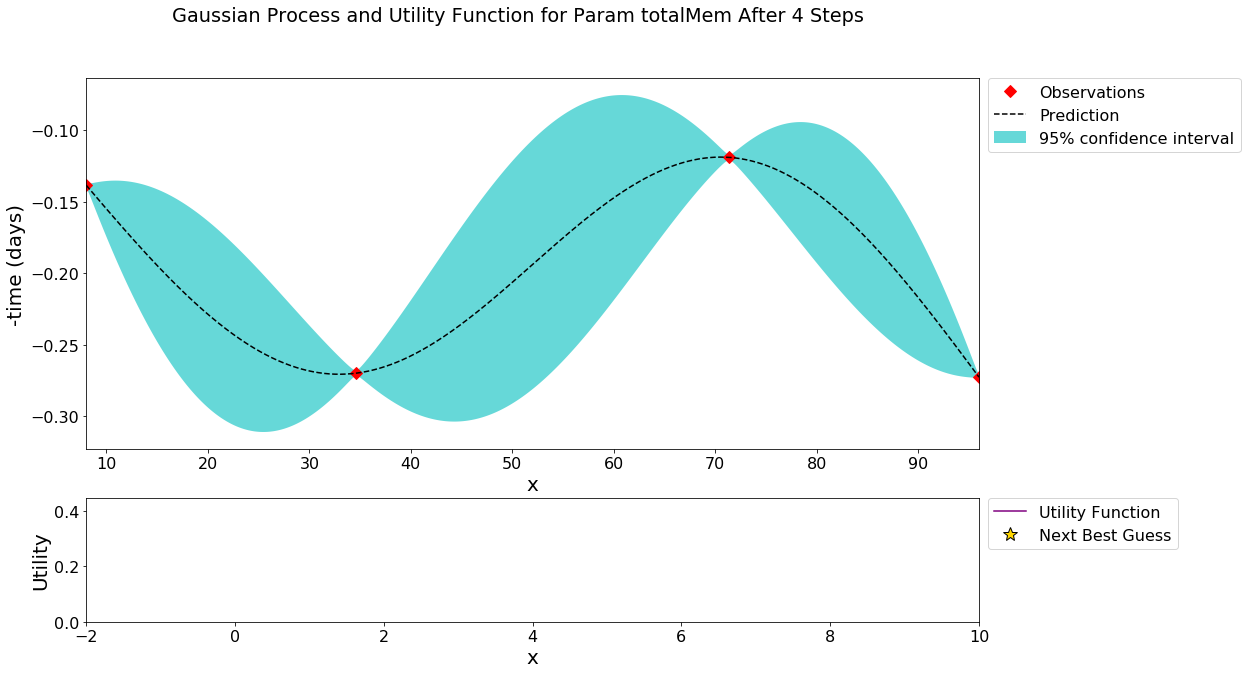

In [127]:
plot_gp(optimizer, orig_utility, params, 'totalMem')

In [171]:
def fitAndPlot3d(gp, x_obs, y_obs, targ_obs, grid, shape, pov, labels, showSamples):
    # fit and predict gp
    gp.fit(np.hstack((x_obs, y_obs)), targ_obs)
    mu, sigma = gp.predict(grid, return_std=True)
    mu = mu.reshape(shape, shape)
    # turn arrays into individual matrices (result is same as np.mesh)
    x_m = grid[:,0].reshape(shape, shape)
    y_m = grid[:,1].reshape(shape, shape)
    
    plt.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(15,8))
    ax = plt.axes(projection='3d')
    ax.view_init(pov[0], pov[1])
    if showSamples:
        ax.scatter(x_obs, y_obs, targ_obs, s=50, c='black', alpha=1, label='observation')
    surf = ax.plot_surface(x_m, y_m, mu, rstride=1, cstride=1, cmap='viridis',
                    edgecolor='none', alpha=0.6, label='prediction')
    
    ax.set_title(labels['title']);
    ax.set_xlabel('\n\n'+labels['xlabel'])
    ax.set_ylabel('\n\n'+labels['ylabel'])
    ax.set_zlabel('\n\n'+labels['zlabel'])
    
    surf._facecolors2d = surf._facecolors3d
    surf._edgecolors2d = surf._edgecolors3d
    ax.legend()
    plt.tight_layout()
    plt.show()

def fitAndPlotContour(gp, x_obs, y_obs, targ_obs, grid, shape, labels, showSamples, annotate):
    # fit and predict gp
    gp.fit(np.hstack((x_obs, y_obs)), targ_obs)
    mu, sigma = gp.predict(grid, return_std=True)
    mu = mu.reshape(shape, shape)
    # turn arrays into individual matrices (result is same as np.mesh)
    x_m = grid[:,0].reshape(shape, shape)
    y_m = grid[:,1].reshape(shape, shape)
    
    plt.figure(figsize=(15,8))
    plt.contourf(x_m, y_m, mu, cmap='viridis')
    plt.colorbar(label=labels['zlabel']);
    if showSamples:
        plt.scatter(x_obs, y_obs, c='black', label='observations')
    if annotate:
        for i, val in enumerate(targ_obs):
            print(f"annotate: {val}, {x_obs[i]}, {y_obs[i]}")
            plt.annotate(s=round(val,3), xy=[x_obs[i], y_obs[i]])
    plt.rcParams.update({'font.size': 16})
    
    plt.title(labels['title'])
    plt.xlabel(labels['xlabel'])
    plt.ylabel(labels['ylabel'])
    plt.legend()
    
    # plt.tight_layout()
    plt.show()

### Plotting Strelka2

In [172]:
# complete data sampling into arrays
dataPoints = []
# with open('./bayes_logs_1549818579.json', 'r') as f:
#     dataPoints = list(map(json.loads, f.readlines()))
# add second data from second run
with open('./bayes_logs_strelkaDebug_1550770909.json', 'r') as f:
    dataPoints = list(map(json.loads, f.readlines()))

shape = 30
params = {
  'nCPUs': (2, 24),
  'totalMem': (8, 98)
}

cpu_obs = np.array([pt['params']['nCPUs'] for pt in dataPoints]).reshape(-1, 1)
mem_obs = np.array([pt['params']['totalMem'] for pt in dataPoints]).reshape(-1, 1)
targ_obs = np.array([pt['target'] for pt in dataPoints])

cpu_xrange = np.linspace(params['nCPUs'][0], params['nCPUs'][1], shape).reshape(-1, 1)
mem_xrange = np.linspace(params['totalMem'][0], params['totalMem'][1], shape).reshape(-1, 1)

grid_cart_prod = np.array([[x0, y0] for x0 in cpu_xrange for y0 in mem_xrange]).reshape(-1, 2)

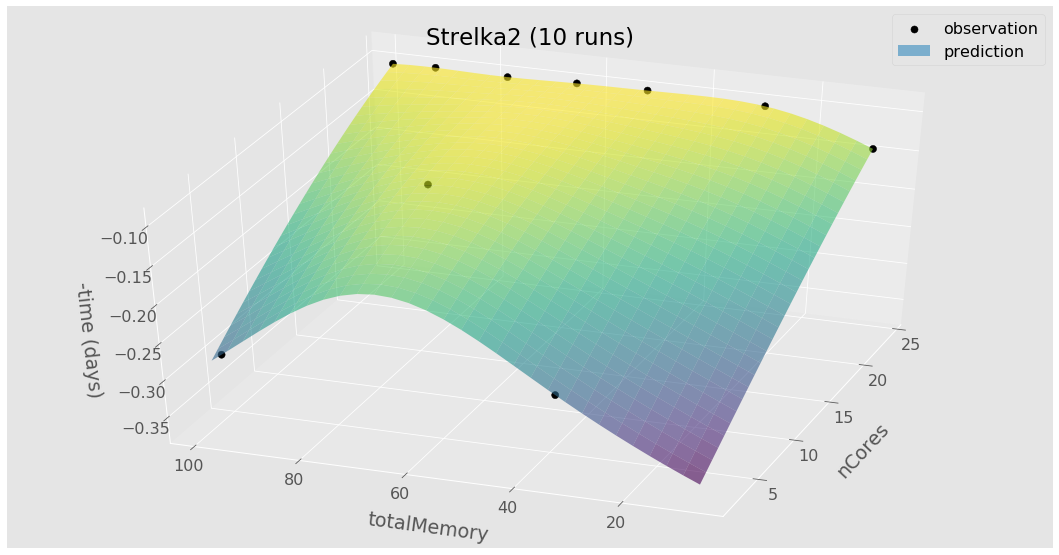

annotate: -0.11898969744642575, [11.1744841], [71.38855542]
annotate: -0.2699817859271058, [2.00251625], [34.60526639]
annotate: -0.27278709055097017, [2.], [96.]
annotate: -0.13843117032889968, [24.], [8.]
annotate: -0.09878389001720482, [24.], [98.]
annotate: -0.09668448339457865, [24.], [50.02524351]
annotate: -0.09950392950464178, [24.], [76.25183154]
annotate: -0.09986809860501024, [24.], [28.2503709]
annotate: -0.09760984851530305, [24.], [63.21544235]
annotate: -0.09777458558755893, [23.99555602], [89.87530875]


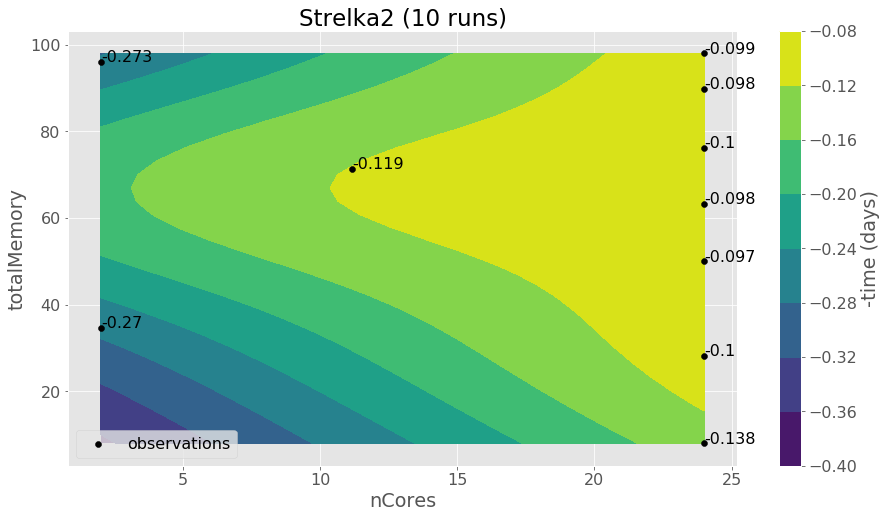

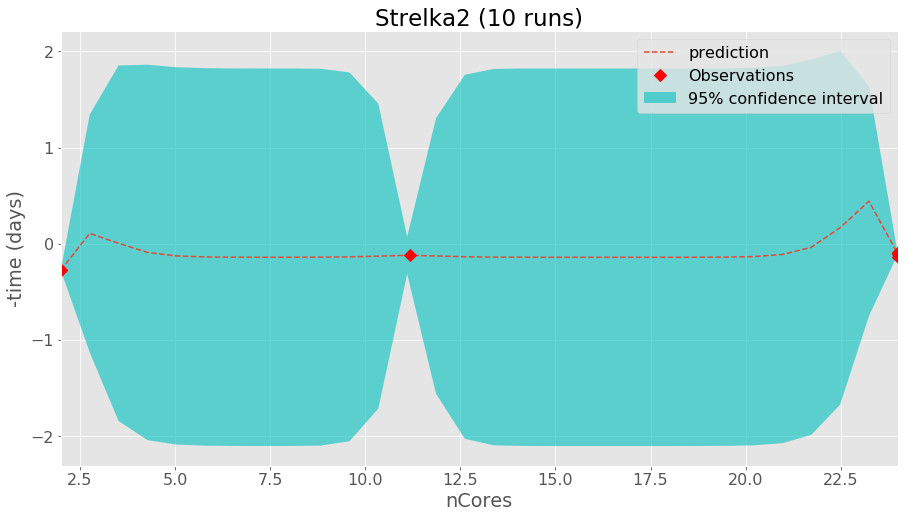

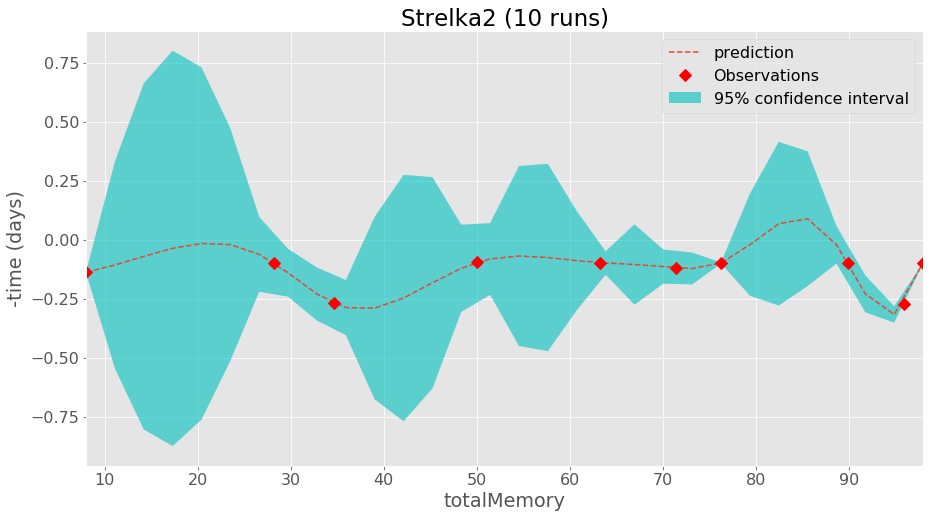

In [173]:
my_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)
title = 'Strelka2 ({} runs)'.format(len(cpu_obs))

labels = {
    'title': title,
    'xlabel': 'nCores',
    'ylabel': 'totalMemory',
    'zlabel': '-time (days)'
}

strelka_df = pd.DataFrame(np.hstack([cpu_obs, mem_obs, targ_obs.reshape(-1, 1)*-1*24*60]), columns=['ncpus', 'totalMem', 'timeMinutes'])
strelka_df.to_csv(title.replace(" ", "_").replace("(", "").replace(")", "")+".csv", index=False)

fitAndPlot3d(my_gp, cpu_obs, mem_obs, targ_obs, grid_cart_prod, shape, (40, 200), labels, True)
fitAndPlotContour(my_gp, cpu_obs, mem_obs, targ_obs, grid_cart_prod, shape, labels, True, True)
fitAndPlot(my_gp, cpu_obs, targ_obs, cpu_xrange, {'xlabel': 'nCores', 'ylabel': '-time (days)', 'title': title})
fitAndPlot(my_gp, mem_obs, targ_obs, mem_xrange, {'xlabel': 'totalMemory', 'ylabel': '-time (days)', 'title': title})

grid shape:  (900, 2)
mu shape:  (900,)
mu reshaped:  (30, 30)


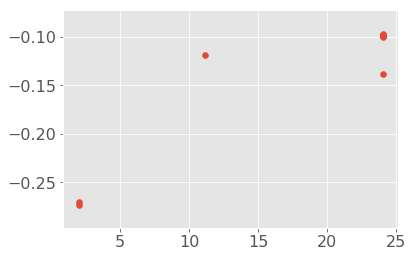

In [174]:
# considering if I should be fitting both variables before plotting univariate....
# Not convinced it actually makes sense. I feel like you could just fit it univariate then plot
# but then I get a weird graph sometimes (e.g. when strelka sampled a lot of points at 24 cpus it gets ugly)
plt.scatter(cpu_obs, targ_obs)
fitAndPlot2(my_gp, cpu_obs, mem_obs, targ_obs, grid_cart_prod, shape, (40, 200), labels, True)

###  Plotting platypus

In [175]:
# complete data sampling into arrays
dataPoints = []
with open('./bayes_logs_platypus_1551116723_cleaned.json', 'r') as f:
    dataPoints = list(map(json.loads, f.readlines()))

params = {
    "nCPU": (4, 24),
    "bufferSize": (1, 4) # 100000, 400000
}
shape = 30

pcpu_obs = np.array([pt['params']['nCPU'] for pt in dataPoints]).reshape(-1, 1)
pbuff_obs = np.array([pt['params']['bufferSize'] for pt in dataPoints]).reshape(-1, 1) / 100000
ptarg_obs = np.array([pt['target'] for pt in dataPoints])

pcpu_xrange = np.linspace(params['nCPU'][0], params['nCPU'][1], shape).reshape(-1, 1)
pbuff_xrange = np.linspace(params['bufferSize'][0], params['bufferSize'][1], shape).reshape(-1, 1)

# calculate cartesian product of variables ORDER MATTERS!
pgrid_cart_prod = np.array([[x0, y0] for x0 in pcpu_xrange for y0 in pbuff_xrange]).reshape(-1, 2)

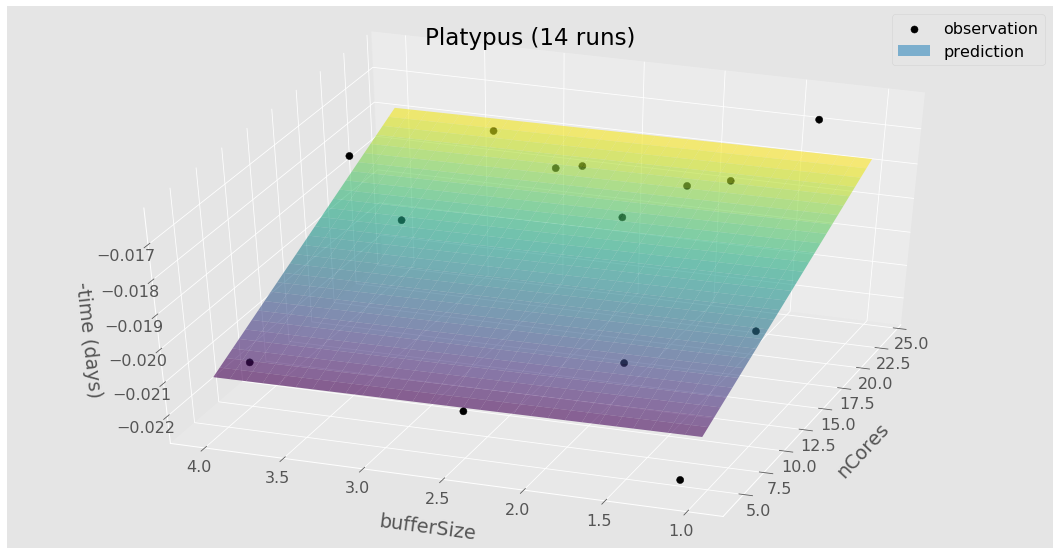

annotate: -0.018766008300913704, [18.40648987], [2.25106601]
annotate: -0.019383517492700505, [10.04665145], [1.00034312]
annotate: -0.018062974890625035, [18.98679887], [3.99997085]
annotate: -0.019795177057385444, [6.49438149], [1.60644991]
annotate: -0.019344501208376, [17.35000138], [3.58493441]
annotate: -0.018236726160954547, [21.66505538], [2.67674455]
annotate: -0.016428549182083873, [22.75173145], [1.28548908]
annotate: -0.01805004624856843, [20.0163469], [1.93794722]
annotate: -0.020672846935965397, [4.72418346], [3.80859214]
annotate: -0.018647291207755053, [22.71320454], [2.90143923]
annotate: -0.021160280817636736, [4.17072824], [2.45682651]
annotate: -0.01808450967349388, [23.9791923], [3.36703644]
annotate: -0.022402255187431972, [4.20361635], [1.13075442]
annotate: -0.018294734038688518, [22.1754428], [1.77446342]


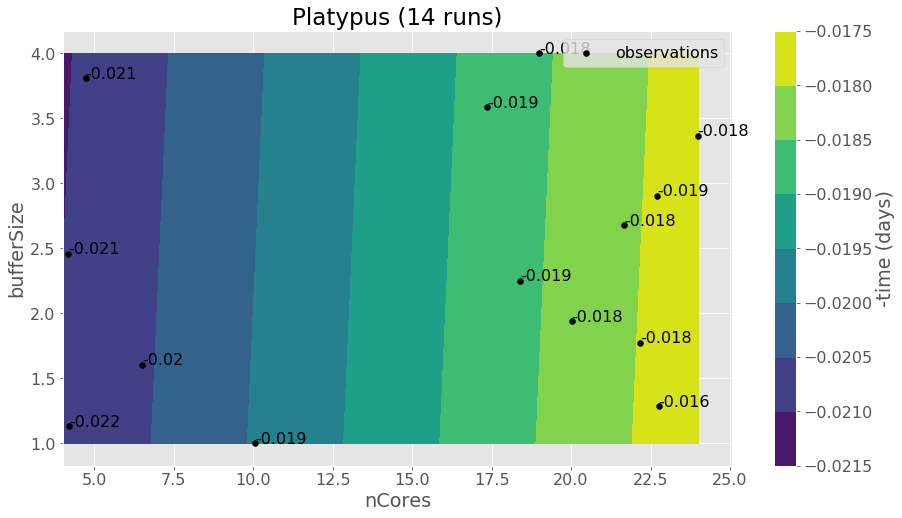

/anaconda3/envs/parsl_py36/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.77151162e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)


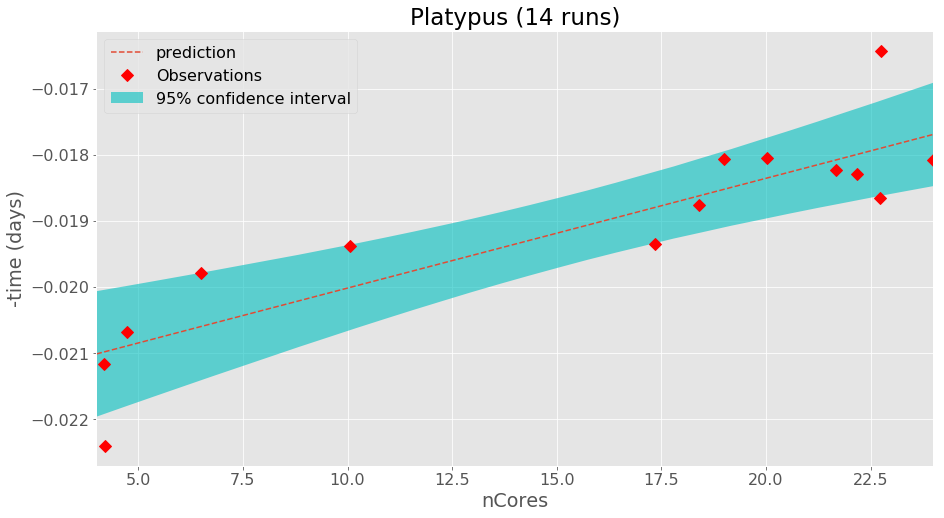

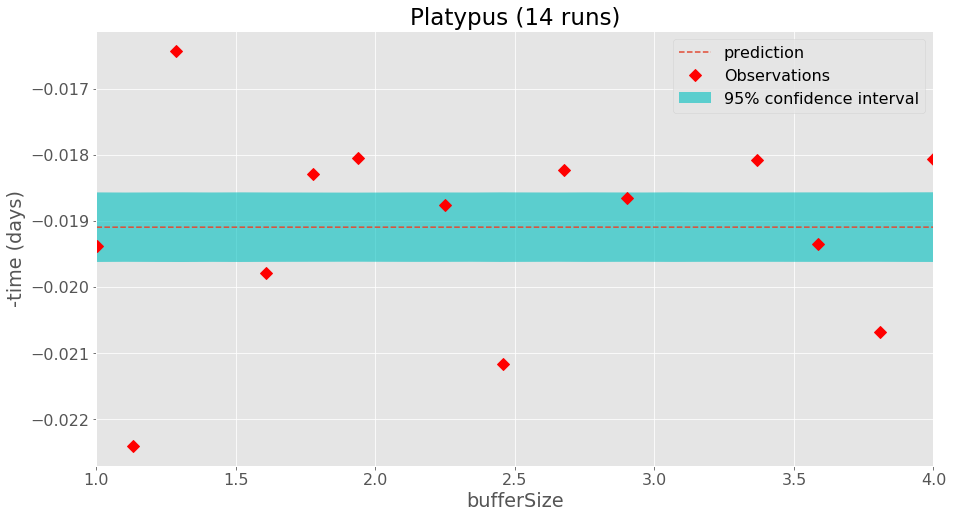

In [176]:
my_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)
title = 'Platypus ({} runs)'.format(len(pcpu_obs))
labels = {
    'title': title,
    'xlabel': 'nCores',
    'ylabel': 'bufferSize',
    'zlabel': '-time (days)'
}

platypus_df = pd.DataFrame(np.hstack([pcpu_obs, pbuff_obs, ptarg_obs.reshape(-1, 1)*-1*24*60]), columns=['ncpus', 'bufferSize', 'timeMinutes'])
platypus_df.to_csv(title.replace(" ", "_").replace("(", "").replace(")", "")+".csv", index=False)

fitAndPlot3d(my_gp, pcpu_obs, pbuff_obs, ptarg_obs, pgrid_cart_prod, shape, (40, 200), labels, True)
fitAndPlotContour(my_gp, pcpu_obs, pbuff_obs, ptarg_obs, pgrid_cart_prod, shape, labels, True, True)
fitAndPlot(my_gp, pcpu_obs, ptarg_obs, pcpu_xrange, {'xlabel': 'nCores', 'ylabel': '-time (days)', 'title': title})
fitAndPlot(my_gp, pbuff_obs, ptarg_obs, pbuff_xrange, {'xlabel': 'bufferSize', 'ylabel': '-time (days)', 'title': title})


## Plotting GATK3

In [177]:
# complete data sampling into arrays
dataPoints = []
with open('./bayes_logs_gatk3_1551162543.json', 'r') as f:
    dataPoints = list(map(json.loads, f.readlines()))

params = {
    "nct": (8, 24),
    "threadsGC": (8, 24)
}
shape = 30

nct_obs = np.array([pt['params']['nct'] for pt in dataPoints]).reshape(-1, 1)
tgc_obs = np.array([pt['params']['threadsGC'] for pt in dataPoints]).reshape(-1, 1)
gatTarg_obs = np.array([pt['target'] for pt in dataPoints])

nct_xrange = np.linspace(params['nct'][0], params['nct'][1], shape).reshape(-1, 1)
tgc_xrange = np.linspace(params['threadsGC'][0], params['threadsGC'][1], shape).reshape(-1, 1)

# calculate cartesian product of variables ORDER MATTERS!
gatGrid_cart_prod = np.array([[x0, y0] for x0 in nct_xrange for y0 in tgc_xrange]).reshape(-1, 2)

/anaconda3/envs/parsl_py36/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.44529999e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)


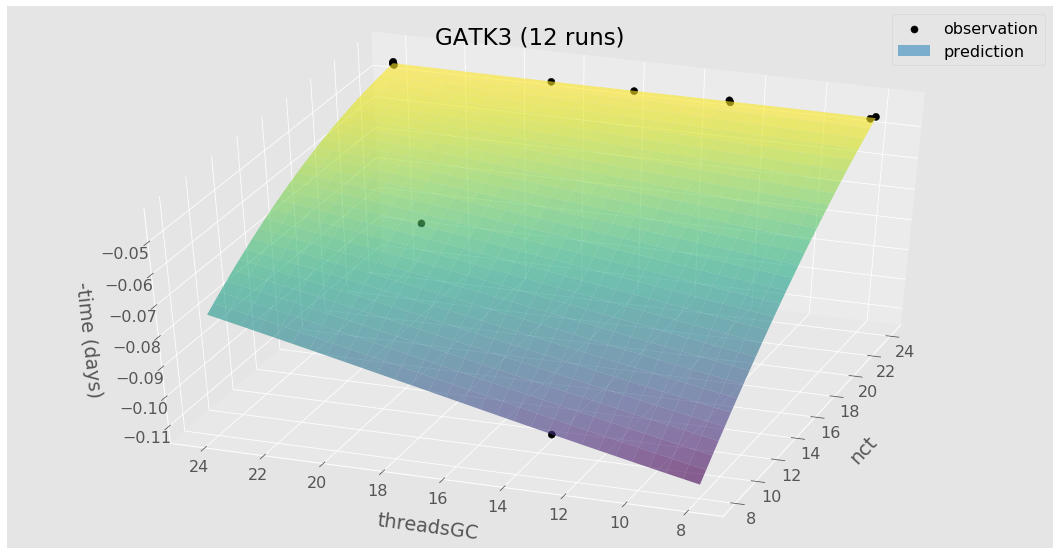

annotate: -0.06250480138041355, [14.67235208], [19.5251919]
annotate: -0.10052032164953373, [8.00183], [12.83732116]
annotate: -0.044730246569271444, [24.], [8.]
annotate: -0.04464120453706494, [24.], [24.]
annotate: -0.04511489470523817, [23.9956888], [15.91289646]
annotate: -0.0450116624434789, [24.], [24.]
annotate: -0.04548293333638597, [23.99204189], [8.17210673]
annotate: -0.04512238883861789, [23.9984567], [18.66909504]
annotate: -0.04468572266123913, [23.99826736], [12.77312292]
annotate: -0.044288721288795824, [23.96933936], [23.97621078]
annotate: -0.045350728644816964, [23.99986299], [23.96682559]
annotate: -0.045248105614273636, [23.99274889], [12.73975438]


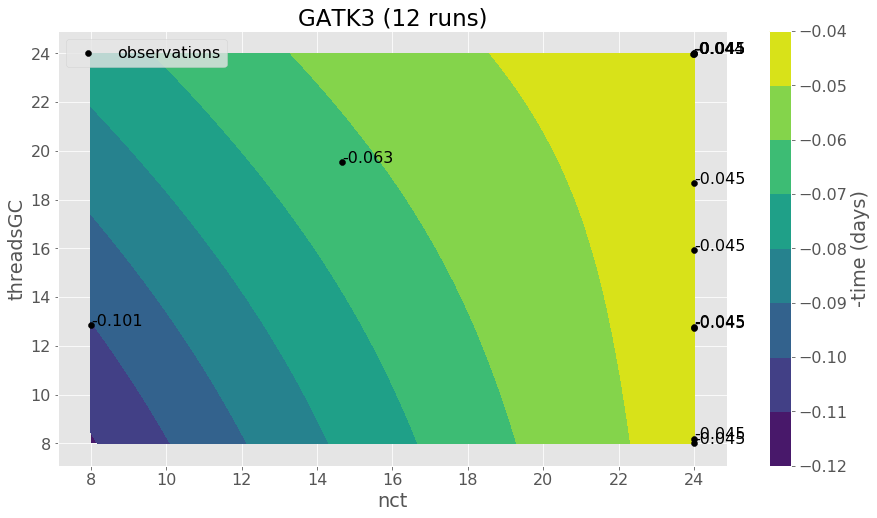

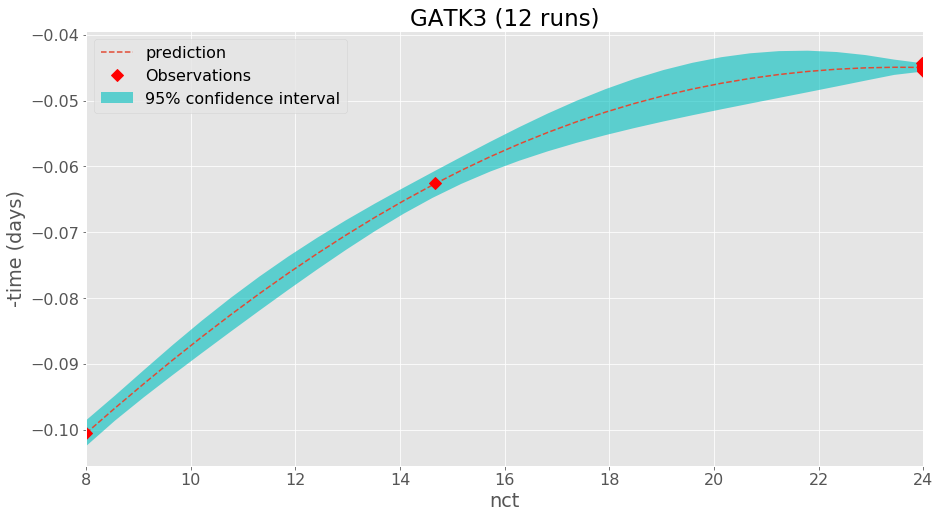

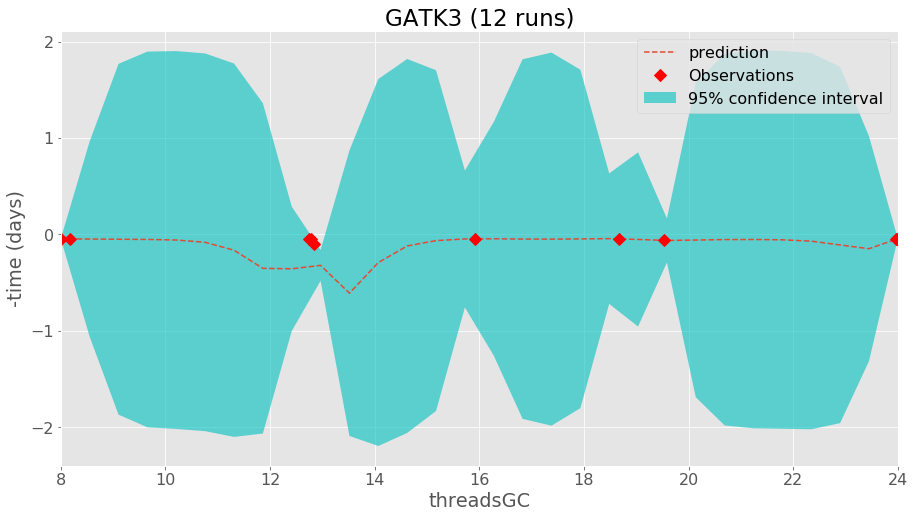

In [178]:
gatk3_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)
title = 'GATK3 ({} runs)'.format(len(nct_obs))
gatk3_labels = {
    'title': title,
    'xlabel': 'nct',
    'ylabel': 'threadsGC',
    'zlabel': '-time (days)'
}

gatk_df = pd.DataFrame(np.hstack([nct_obs, tgc_obs, gatTarg_obs.reshape(-1, 1)*-1*24*60]), columns=['nct', 'threadsGC', 'timeMinutes'])
gatk_df.to_csv(title.replace(" ", "_").replace("(", "").replace(")", "")+".csv", index=False)

fitAndPlot3d(gatk3_gp, nct_obs, tgc_obs, gatTarg_obs, gatGrid_cart_prod, shape, (40, 200), gatk3_labels, True)
fitAndPlotContour(gatk3_gp, nct_obs, tgc_obs, gatTarg_obs, gatGrid_cart_prod, shape, gatk3_labels, True, True)
fitAndPlot(gatk3_gp, nct_obs, gatTarg_obs, nct_xrange, {'xlabel': 'nct', 'ylabel': '-time (days)', 'title': title})
fitAndPlot(gatk3_gp, tgc_obs, gatTarg_obs, tgc_xrange, {'xlabel': 'threadsGC', 'ylabel': '-time (days)', 'title': title})

## Plotting Platypus - Grid search

In [179]:
# complete data sampling into arrays
dataPoints = []
gs_df = pd.read_csv("my_logs_platypusGrid_1551207188.csv")

params = {
    "nCPU": (4, 24),
    "bufferSize": (1, 4)
}
shape = 30

gs_pcpu_obs = np.array(gs_df['nCPU']).reshape(-1, 1)
gs_pbuff_obs = np.array(gs_df['bufferSize']).reshape(-1, 1) / 100000
gs_ptarg_obs = np.array(gs_df['negDays'])

gs_pcpu_xrange = np.linspace(params['nCPU'][0], params['nCPU'][1], shape).reshape(-1, 1)
gs_pbuff_xrange = np.linspace(params['bufferSize'][0], params['bufferSize'][1], shape).reshape(-1, 1)

# calculate cartesian product of variables ORDER MATTERS!
gs_pgrid_cart_prod = np.array([[x0, y0] for x0 in gs_pcpu_xrange for y0 in gs_pbuff_xrange]).reshape(-1, 2)

/anaconda3/envs/parsl_py36/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.87736995e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)


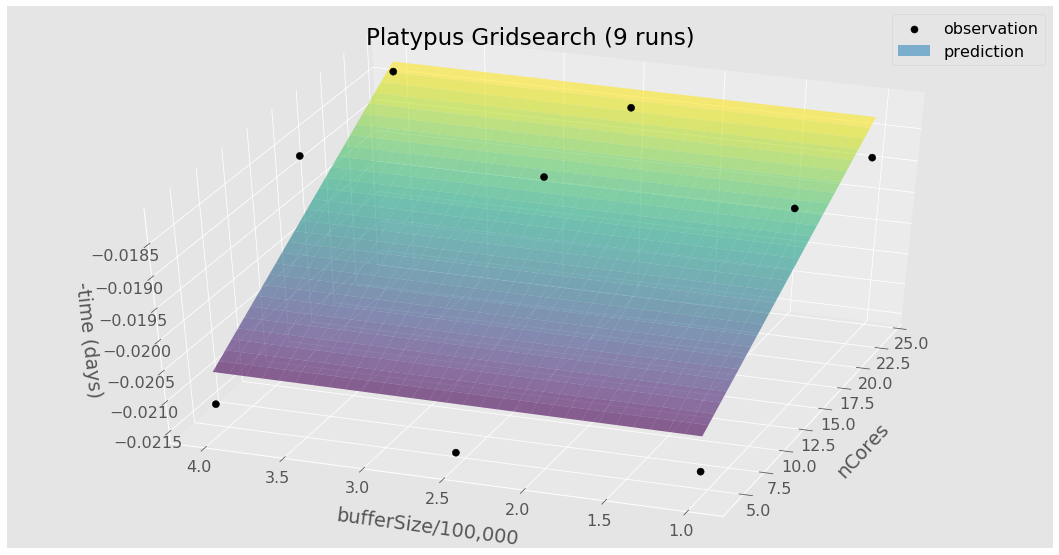

annotate: -0.021239378507490508, [4.], [1.]
annotate: -0.0214562973573252, [4.], [2.5]
annotate: -0.02116478046057401, [4.], [4.]
annotate: -0.01840673786622507, [14.], [1.]
annotate: -0.018374228513351198, [14.], [2.5]
annotate: -0.01848808201374831, [14.], [4.]
annotate: -0.01883815523650911, [24.], [1.]
annotate: -0.018489965343916857, [24.], [2.5]
annotate: -0.0183446049000378, [24.], [4.]


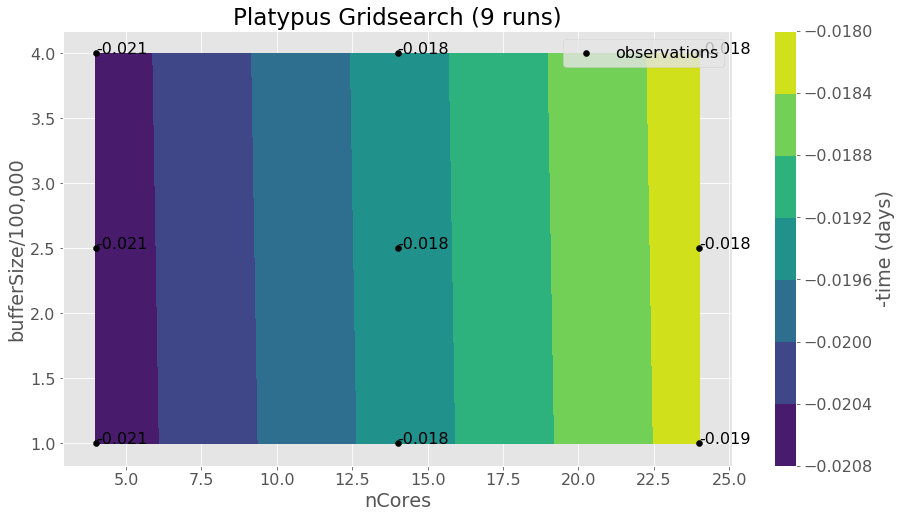

/anaconda3/envs/parsl_py36/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6.15830173e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)


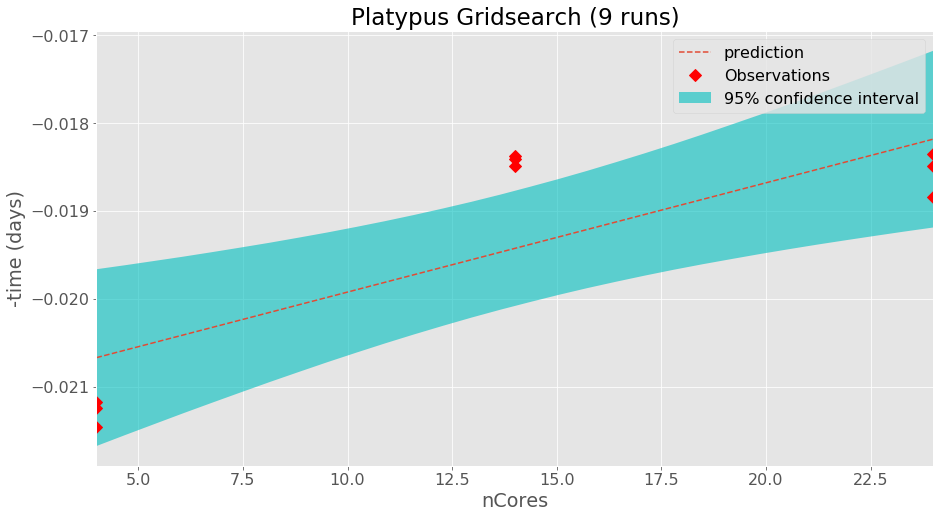

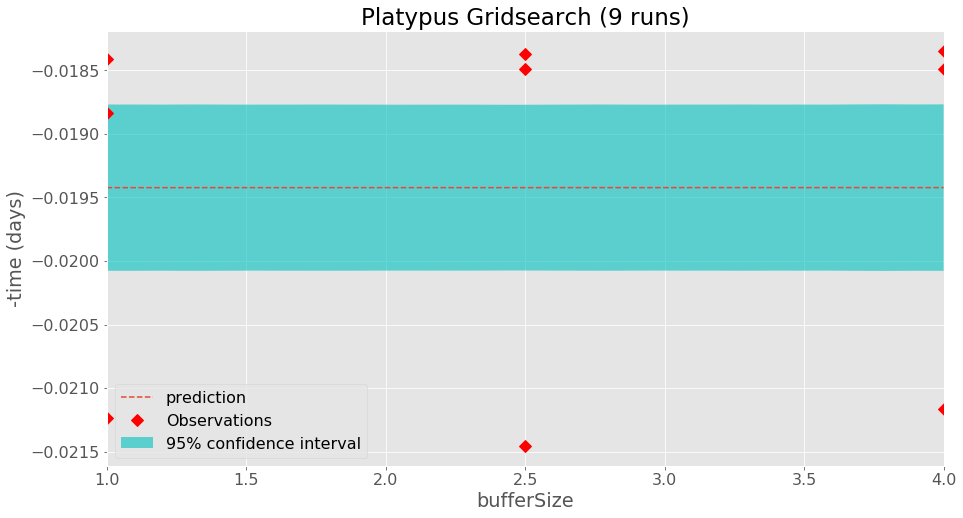

In [180]:
# plt.scatter(pcpu_obs, ptarg_obs)
# plt.xlim(4,24)
# plt.ylim(-0.024, -0.015)
my_gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=25,
    random_state=bayes_opt.util.ensure_rng(None),
)
title = 'Platypus Gridsearch ({} runs)'.format(len(gs_pcpu_obs))
labels = {
    'title': title,
    'xlabel': 'nCores',
    'ylabel': 'bufferSize/100,000',
    'zlabel': '-time (days)'
}

platypus_df = pd.DataFrame(np.hstack([gs_pcpu_obs, gs_pbuff_obs, gs_ptarg_obs.reshape(-1, 1)*-1*24*60]), columns=['ncpus', 'bufferSize', 'timeMinutes'])
platypus_df.to_csv(title.replace(" ", "_").replace("(", "").replace(")", "")+".csv", index=False)

fitAndPlot3d(my_gp, gs_pcpu_obs, gs_pbuff_obs, gs_ptarg_obs, gs_pgrid_cart_prod, shape, (40, 200), labels, True)
fitAndPlotContour(my_gp, gs_pcpu_obs, gs_pbuff_obs, gs_ptarg_obs, gs_pgrid_cart_prod, shape, labels, True, True)
fitAndPlot(my_gp, gs_pcpu_obs, gs_ptarg_obs, gs_pcpu_xrange, {'xlabel': 'nCores', 'ylabel': '-time (days)', 'title': title})
fitAndPlot(my_gp, gs_pbuff_obs, gs_ptarg_obs, gs_pbuff_xrange, {'xlabel': 'bufferSize', 'ylabel': '-time (days)', 'title': title})

## Plotting Platypus gridsearch vs bayesopt results

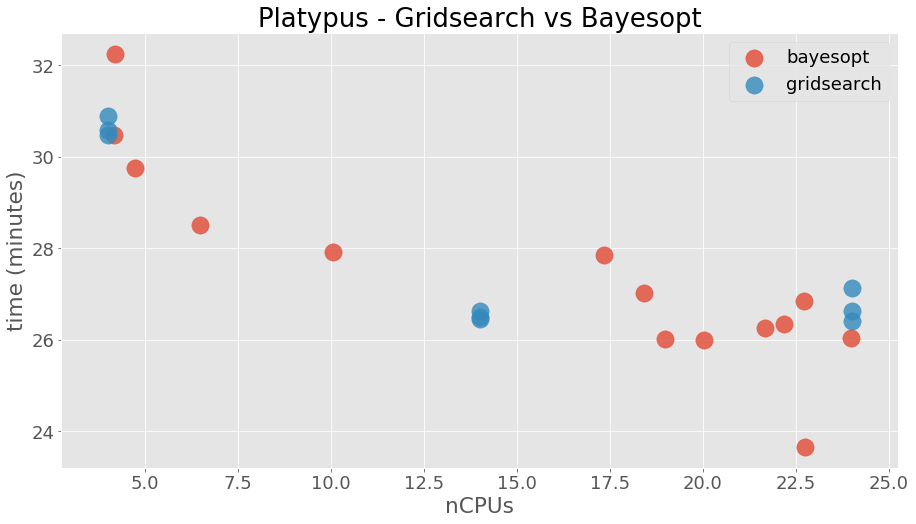

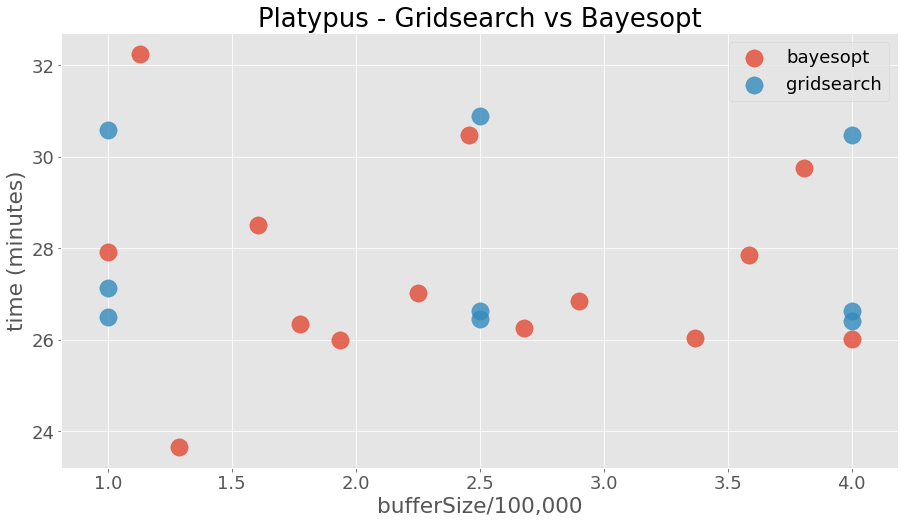

In [183]:
matplotlib.style.use('ggplot')
def plotComparison(a_x, a_y, b_x, b_y, labels):
    plt.rc('font', size=18)
    plt.figure(figsize=(15,8))
    plt.title(labels['title'])
    plt.scatter(a_x, a_y, label=labels['a'], alpha=0.8, s=300)
    plt.scatter(b_x, b_y, label=labels['b'], alpha=0.8, s=300)
    plt.legend(loc="upper right")
    plt.xlabel(labels['x'])
    plt.ylabel(labels['y'])

cpuLabels = {
    'title': 'Platypus - Gridsearch vs Bayesopt',
    'a': 'bayesopt',
    'b': 'gridsearch',
    'x': 'nCPUs',
    'y': 'time (minutes)'
}
buffLabels = {
    'title': 'Platypus - Gridsearch vs Bayesopt',
    'a': 'bayesopt',
    'b': 'gridsearch',
    'x': 'bufferSize/100,000',
    'y': 'time (minutes)'
}
plotComparison(pcpu_obs, ptarg_obs*24*60*-1, gs_pcpu_obs, gs_ptarg_obs*24*60*-1, cpuLabels)
plotComparison(pbuff_obs, ptarg_obs*24*60*-1, gs_pbuff_obs, gs_ptarg_obs*24*60*-1, buffLabels)